Import important parameter

In [77]:
inputsize =11**2
e = 0.1000

Import Package

In [78]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
import pyamg
import dmg.gallery as gallery
import dmg.dgmg as dgmg
import dmg.gmg_linear as gmg_linear
import dmg.classical_amg as classical_amg
from mpl_toolkits.mplot3d import Axes3D
import xlsxwriter
from scipy.ndimage import convolve

Define function

In [79]:
def Restriction(inputsize):
    inputsize = int(inputsize)
    sqrtinputsize = int(np.sqrt(inputsize))     
    sqrtoutputsize = int(sqrtinputsize/2)
    outputsize = int(sqrtoutputsize**2)
    OUTPUT = np.zeros([outputsize, inputsize])
    for j in range(sqrtoutputsize):
        for i in range(sqrtoutputsize):
            OUTPUT[i+sqrtoutputsize*j][2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][1+2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2+2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][1+sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/4
            OUTPUT[i+sqrtoutputsize*j][2+sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2*sqrtinputsize +
                                       2*i+j*2*sqrtinputsize] = 1/16
            OUTPUT[i+sqrtoutputsize*j][1+2 *
                                       sqrtinputsize + 2*i+j*2*sqrtinputsize] = 1/8
            OUTPUT[i+sqrtoutputsize*j][2+2 *
                                       sqrtinputsize+2*i+j*2*sqrtinputsize] = 1/16
    return OUTPUT

def Poisson(inputsize):
    inputsize = int(inputsize)
    sqrtinputsize = int(np.sqrt(inputsize))     
    sqrtoutputsize = int(sqrtinputsize/2)
    outputsize = int(sqrtoutputsize**2)
    OUTPUT = np.zeros([outputsize, inputsize])
    A1 = 2*np.eye(sqrtinputsize)
    for i in range(sqrtinputsize-1):
        A1[i, i+1] = -1
        A1[i+1, i] = -1
    I = np.eye(sqrtinputsize)
    OUTPUT = (np.kron(I, A1)+np.kron(A1, I))
    return OUTPUT


def Multigrid_circle(inputsize, A_A, B, R_A, s, w, error):
    A = np.matrix(A_A)
    P = 4.*np.transpose(R_A)
    R = np.matrix(R_A)
    M = np.matrix(w**(-1)*np.diag(np.diag(A)))
    K = M - A
    C = np.linalg.inv(M)*K
    b = np.linalg.inv(M)*B
    U0 = np.matrix(np.zeros([inputsize, 1]))
    RESIDUAL = []
    Residual=1
    i=0
    while Residual > error:
        for j in range(s):
            U0 = C*U0+b
        r = B - A*U0
        Residual = np.linalg.norm(r,2)
        rc = R*r
        Ac = R*A*P
        Uc = np.linalg.solve(Ac, rc)
        U = U0 + P*Uc
        for k in range(s):
            U = C*U+b
        U0 = U
        RESIDUAL.append(Residual)
        i=i+1
        print("Residual = {}".format(Residual))
        print("Interation = {}".format(i))
        print("===================")
    return U0, RESIDUAL

def rho(inputsize,A,P,R,w,s):
    M = (w**(-1)) * np.diag(np.diag(A))
    K = M - A
    MK = np.matmul(np.linalg.inv(M),K)
    I = np.eye(inputsize)
    IPRAPRA = I - np.matmul(np.matmul(np.matmul(P,np.linalg.inv(np.matmul(np.matmul(R,A),P))),R),A)
    C = np.matmul(np.matmul(MK,IPRAPRA),MK)
    for i in range(5):
        C = np.matmul(C,C)
    radius = np.linalg.norm(C)**(1/32)
    return radius

def optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam):
    rhoold = rho(inputsize,A1,4*np.transpose(R),R,w,s)
    device = torch.device('cpu')
    R = torch.tensor(R,dtype = torch.double, requires_grad=True,device=device)
    w = torch.tensor(w,dtype = torch.double, requires_grad=True, device=device)
    lam = torch.tensor(lam,dtype = torch.double, requires_grad=True, device=device)
    A = torch.tensor(A1,dtype = torch.double, device=device)
    P = 4*torch.t(R)
    M = (w**(-1)) * torch.diag(torch.diag(A))
    K = M - A
    MK = torch.mm(torch.inverse(M),K)
    I = torch.eye(inputsize,dtype = torch.double, device=device)
    I1 = torch.ones([inputsize,1],dtype = torch.double, device=device)
    I2 = torch.ones([outputsize,1],dtype = torch.double, device=device)
    IPRAPRA = I - torch.mm(torch.mm(torch.mm(P,torch.inverse(torch.mm(torch.mm(R,A),P))),R),A)
    C = torch.mm(torch.mm(MK,IPRAPRA),MK)
    for i in range(5):
        C = torch.mm(C,C)
    loss = torch.norm(C)**(1/32) + torch.mm(lam,torch.mm(R,I1) - I2)
    loss.backward()
    with torch.no_grad():
        R-=learning_rate*R.grad
        w-=learning_rate*w.grad 
        lam-=learning_rate*lam.grad
    R = R.detach().numpy()
    w = w.detach().numpy()
    lam = lam.detach().numpy()
    rhonew = rho(inputsize,A1,4*np.transpose(R),R,w,s)
    return R, w, lam, rhoold, rhonew

def direct_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate, lam):
    Rhoold = rho(inputsize,A1,4*np.transpose(R),R,w,s)
    Rhonew = [Rhoold]
    for i in range(100):
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        R = Rnew
        w = wnew
        lam = lamnew
        print("rho = {}".format(rhonew))
        print("===================")
        Rhonew.append(rhonew)
        i+=1
    print("======End======")
    return R, w, Rhoold, Rhonew

def homotopy_optimizer_GD(inputsize, A0, A1, R, w, s, learning_rate ,accept_radius ,step_length,lam):
    Rhoold = rho(inputsize,A1,4*np.transpose(R),R,w,s)
    Radius = [Rhoold]
    L = step_length
    print("======Section 1======")
    while L < 1:
        M = (1-L)*A0 + L*A1
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, M, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        if rhonew > accept_radius:
            step_length = 0.1*step_length
            learning_rate = 0.1*learning_rate
            print('Decrease the step_length, learning_rate and Restart!!')
            print("step_length = {}".format(step_length))      
            print("learning_rate = {}".format(learning_rate))
            print("rhonew = {}".format(rhonew))
            print("===================")
            R = Restriction(inputsize)
            lam = np.zeros([1,outputsize])
            w = 2/3
            L = step_length
        else:
            R = Rnew
            w = wnew
            L += step_length
            lam = lamnew
            print("L = {}".format(L))
            print("rho = {}".format(rhonew))
            print("===================")
    print("======Section 2======")
    i = 0
    while rhoold>rhonew and i <20000:
        Rnew, wnew, lamnew, rhoold, rhonew = optimizer_GD(inputsize, A1, R, w, s, learning_rate, lam)
        Radius.append(rhonew)
        R = Rnew
        w = wnew
        lam = lamnew
        print("the {} steps".format(i))
        print("rho = {}".format(rhonew))
        print("===================")
        i+=1            
    Rhonew = rhonew
    print("======End======")
    return R, w, Rhoold, Rhonew, Radius

Define parameter

In [80]:
s = 1
w = 2/3
error=10e-11
def u_real(x, y): return np.sin(np.pi*3*x)*np.sin(np.pi*5*y)
def rightf(x, y): return  34*np.pi**2*np.sin(3*np.pi*x)*np.sin(5*np.pi*y)*(np.cos((x + y)/e) + 2) + (3*np.pi*np.cos(3*np.pi*x)*np.sin(5*np.pi*y)*np.sin((x + y)/e))/e + (5*np.pi*np.cos(5*np.pi*y)*np.sin(3*np.pi*x)*np.sin((x + y)/e))/e
def a(x, y): return 2+np.cos((x+y)/e)
sqrtinputsize = int(np.sqrt(inputsize))     
sqrtoutputsize = int(sqrtinputsize/2)
outputsize = int(sqrtoutputsize**2)
h = 1/(sqrtinputsize-1)
H = 1/(sqrtoutputsize-1)
A0 = Poisson(inputsize)
num_levels=2
n=sqrtinputsize
kx = np.zeros([n,n+1])
ky = np.zeros([n+1,n])
for i in range(n):
    for j in range(n+1):
        kx[i][j] = a((j-0.5)*h,i*h)
for i in range(n+1):
    for j in range(n):
        ky[i][j] = a(j*h,(i-0.5)*h)    
A1 = gallery.nonlinearPoisson((n,n), kx, ky)
n = inputsize
linear_gmg = gmg_linear.LinearGMG(A1, max_levels=num_levels)
print("Linear = {}".format(linear_gmg.compute_rho()))
[X, Y] = np.meshgrid(np.linspace(0, 1, sqrtinputsize),np.linspace(0, 1, sqrtinputsize))
RightF = rightf(X,Y)*h**2
RightF = RightF.reshape(inputsize, 1)
Ureal = u_real(X,Y).reshape(inputsize, 1)
Media = a(X,Y)
R = Restriction(inputsize)
P = 4*np.transpose(R)

Linear = 0.18383892589158893


GMM on fine grid

In [81]:
GMM_U, GMM_Res = Multigrid_circle(inputsize, A1.to_full(), RightF, R, s, w, error)

Residual = 18.37659410893113
Interation = 1
Residual = 1.4220102073393164
Interation = 2
Residual = 0.3845292832205686
Interation = 3
Residual = 0.12900032968451766
Interation = 4
Residual = 0.047177985632388564
Interation = 5
Residual = 0.018083976508678767
Interation = 6
Residual = 0.0071258034880161995
Interation = 7
Residual = 0.002854936350000398
Interation = 8
Residual = 0.001155471447313496
Interation = 9
Residual = 0.0004705824213992502
Interation = 10
Residual = 0.0001924084263541685
Interation = 11
Residual = 7.887397775216008e-05
Interation = 12
Residual = 3.239052945461924e-05
Interation = 13
Residual = 1.331906811372249e-05
Interation = 14
Residual = 5.482541186124643e-06
Interation = 15
Residual = 2.2587704361274922e-06
Interation = 16
Residual = 9.313288049175959e-07
Interation = 17
Residual = 3.842821900087654e-07
Interation = 18
Residual = 1.5867162543780634e-07
Interation = 19
Residual = 6.556038067767219e-08
Interation = 20
Residual = 2.7106390570017317e-08
Interatio

Error GMM on fine grid

In [82]:
UREAL = Ureal.reshape(sqrtinputsize,sqrtinputsize)
GMMU = GMM_U.reshape(sqrtinputsize,sqrtinputsize)
deltaU = GMMU - UREAL
energynorm = np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=0),np.gradient(UREAL,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=1),np.gradient(UREAL,h,axis=1)),Media)*(h**2)))
l2norm = np.sqrt((np.linalg.norm(UREAL)**2)*(h**2))
h1norm = np.sqrt((np.linalg.norm(np.gradient(UREAL,h,axis=0))**2+np.linalg.norm(np.gradient(UREAL,h,axis=1))**2+np.linalg.norm(UREAL)**2)*(h**2))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),Media)*(h**2))))
print('L2 norm: ')
print(np.sqrt((np.linalg.norm(deltaU)**2)*(h**2)))
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2)))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),Media)*(h**2)))/energynorm)
print('L2 norm: ')
print(np.sqrt((np.linalg.norm(deltaU)**2)*(h**2))/l2norm)
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2))/h1norm)

Energy norm: 
3.359098727627814
L2 norm: 
0.2999192116112388
H1 norm: 
2.4683064096501073
Energy norm: 
0.3379108552953116
L2 norm: 
0.5998384232224776
H1 norm: 
0.3494724728755205


Solution

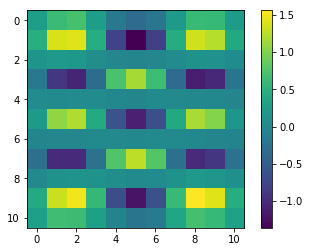

In [83]:
plt.imshow(GMM_U.reshape(sqrtinputsize,sqrtinputsize))
plt.colorbar()

Residual

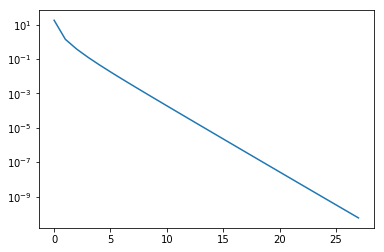

In [84]:
plt.semilogy(GMM_Res)

Radius

In [86]:
GMM_Radius = rho(inputsize,A1.to_full(),4*np.transpose(R),R,w,s)
print('GMM_Radius = {}'.format(GMM_Radius))

GMM_Radius = 0.4303569039923038


Global DMM optimization

In [87]:
Rnew, wnew, Rhoold, Rhonew, Radius = homotopy_optimizer_GD(inputsize, A0, A1.to_full(), R,  2/3, s, 
                                                           learning_rate = 1e-4,accept_radius =
                                                           GMM_Radius*10,step_length = 1e-2, lam = np.zeros([1,outputsize]))

======Section 1======
L = 0.02
rho = 0.43428415975625967
L = 0.03
rho = 0.43423185000378134
L = 0.04
rho = 0.43417578663087353
L = 0.05
rho = 0.43411618035749044
L = 0.060000000000000005
rho = 0.4340532341684295
L = 0.07
rho = 0.4339871433042931
L = 0.08
rho = 0.43391809530946307
L = 0.09
rho = 0.43384627012549726
L = 0.09999999999999999
rho = 0.43377184022033505
L = 0.10999999999999999
rho = 0.433694970745351
L = 0.11999999999999998
rho = 0.4336158197136707
L = 0.12999999999999998
rho = 0.43353453819431725
L = 0.13999999999999999
rho = 0.433451270517713
L = 0.15
rho = 0.4333661544888628
L = 0.16
rho = 0.4332793216052145
L = 0.17
rho = 0.4331908972767497
L = 0.18000000000000002
rho = 0.43310100104632165
L = 0.19000000000000003
rho = 0.43300974680864573
L = 0.20000000000000004
rho = 0.4329172430266686
L = 0.21000000000000005
rho = 0.4328235929443139
L = 0.22000000000000006
rho = 0.4327288947948184
L = 0.23000000000000007
rho = 0.43263324200406583
L = 0.24000000000000007
rho = 0.43253672

the 45 steps
rho = 0.4232913134499811
the 46 steps
rho = 0.4232422637175177
the 47 steps
rho = 0.4231932203615389
the 48 steps
rho = 0.4231441833777209
the 49 steps
rho = 0.42309515276177717
the 50 steps
rho = 0.42304612850945794
the 51 steps
rho = 0.42299711061655
the 52 steps
rho = 0.4229480990788756
the 53 steps
rho = 0.422899093892293
the 54 steps
rho = 0.42285009505269494
the 55 steps
rho = 0.4228011025560089
the 56 steps
rho = 0.42275211639819643
the 57 steps
rho = 0.42270313657525294
the 58 steps
rho = 0.42265416308320664
the 59 steps
rho = 0.422605195918119
the 60 steps
rho = 0.4225562350760838
the 61 steps
rho = 0.4225072805532269
the 62 steps
rho = 0.42245833234570535
the 63 steps
rho = 0.4224093904497077
the 64 steps
rho = 0.4223604548614536
the 65 steps
rho = 0.42231152557719287
the 66 steps
rho = 0.42226260259320514
the 67 steps
rho = 0.4222136859058002
the 68 steps
rho = 0.42216477551131687
the 69 steps
rho = 0.4221158714061231
the 70 steps
rho = 0.42206697358661543
the 7

the 194 steps
rho = 0.41605140840320015
the 195 steps
rho = 0.41600327467793974
the 196 steps
rho = 0.4159551469306158
the 197 steps
rho = 0.41590702515951233
the 198 steps
rho = 0.4158589093629203
the 199 steps
rho = 0.4158107995391375
the 200 steps
rho = 0.4157626956864688
the 201 steps
rho = 0.41571459780322556
the 202 steps
rho = 0.41566650588772597
the 203 steps
rho = 0.41561841993829507
the 204 steps
rho = 0.4155703399532643
the 205 steps
rho = 0.4155222659309717
the 206 steps
rho = 0.41547419786976175
the 207 steps
rho = 0.4154261357679853
the 208 steps
rho = 0.41537807962399975
the 209 steps
rho = 0.41533002943616865
the 210 steps
rho = 0.4152819852028617
the 211 steps
rho = 0.415233946922455
the 212 steps
rho = 0.41518591459333065
the 213 steps
rho = 0.41513788821387676
the 214 steps
rho = 0.41508986778248746
the 215 steps
rho = 0.41504185329756316
the 216 steps
rho = 0.41499384475750967
the 217 steps
rho = 0.414945842160739
the 218 steps
rho = 0.4148978455056687
the 219 steps

the 346 steps
rho = 0.40880281699880294
the 347 steps
rho = 0.40875557518445005
the 348 steps
rho = 0.4087083391410609
the 349 steps
rho = 0.408661108867512
the 350 steps
rho = 0.4086138843626815
the 351 steps
rho = 0.4085666656254496
the 352 steps
rho = 0.40851945265469874
the 353 steps
rho = 0.4084722454493132
the 354 steps
rho = 0.4084250440081792
the 355 steps
rho = 0.4083778483301851
the 356 steps
rho = 0.40833065841422095
the 357 steps
rho = 0.4082834742591789
the 358 steps
rho = 0.4082362958639531
the 359 steps
rho = 0.4081891232274393
the 360 steps
rho = 0.40814195634853534
the 361 steps
rho = 0.4080947952261411
the 362 steps
rho = 0.40804763985915804
the 363 steps
rho = 0.40800049024648966
the 364 steps
rho = 0.4079533463870412
the 365 steps
rho = 0.40790620827971985
the 366 steps
rho = 0.4078590759234345
the 367 steps
rho = 0.40781194931709586
the 368 steps
rho = 0.4077648284596165
the 369 steps
rho = 0.40771771334991064
the 370 steps
rho = 0.40767060398689453
the 371 steps
r

the 494 steps
rho = 0.4018732426435399
the 495 steps
rho = 0.4018268435672589
the 496 steps
rho = 0.4017804501120854
the 497 steps
rho = 0.40173406227709024
the 498 steps
rho = 0.40168768006134503
the 499 steps
rho = 0.40164130346392257
the 500 steps
rho = 0.40159493248389583
the 501 steps
rho = 0.40154856712033926
the 502 steps
rho = 0.40150220737232767
the 503 steps
rho = 0.4014558532389369
the 504 steps
rho = 0.4014095047192434
the 505 steps
rho = 0.40136316181232473
the 506 steps
rho = 0.4013168245172587
the 507 steps
rho = 0.4012704928331246
the 508 steps
rho = 0.40122416675900197
the 509 steps
rho = 0.4011778462939712
the 510 steps
rho = 0.4011315314371137
the 511 steps
rho = 0.4010852221875115
the 512 steps
rho = 0.40103891854424734
the 513 steps
rho = 0.4009926205064048
the 514 steps
rho = 0.4009463280730681
the 515 steps
rho = 0.40090004124332246
the 516 steps
rho = 0.40085376001625356
the 517 steps
rho = 0.400807484390948
the 518 steps
rho = 0.40076121436649315
the 519 steps


the 645 steps
rho = 0.39493013344974814
the 646 steps
rho = 0.39488457302752544
the 647 steps
rho = 0.3948390180935307
the 648 steps
rho = 0.3947934686469237
the 649 steps
rho = 0.39474792468686454
the 650 steps
rho = 0.39470238621251375
the 651 steps
rho = 0.39465685322303234
the 652 steps
rho = 0.3946113257175819
the 653 steps
rho = 0.3945658036953241
the 654 steps
rho = 0.39452028715542115
the 655 steps
rho = 0.394474776097036
the 656 steps
rho = 0.3944292705193314
the 657 steps
rho = 0.3943837704214711
the 658 steps
rho = 0.3943382758026188
the 659 steps
rho = 0.3942927866619389
the 660 steps
rho = 0.3942473029985961
the 661 steps
rho = 0.39420182481175564
the 662 steps
rho = 0.39415635210058286
the 663 steps
rho = 0.3941108848642436
the 664 steps
rho = 0.39406542310190446
the 665 steps
rho = 0.3940199668127319
the 666 steps
rho = 0.39397451599589317
the 667 steps
rho = 0.39392907065055566
the 668 steps
rho = 0.3938836307758874
the 669 steps
rho = 0.39383819637105677
the 670 steps


the 799 steps
rho = 0.38797799234023633
the 800 steps
rho = 0.38793326743037654
the 801 steps
rho = 0.3878885478836237
the 802 steps
rho = 0.3878438336991903
the 803 steps
rho = 0.38779912487628837
the 804 steps
rho = 0.38775442141413097
the 805 steps
rho = 0.38770972331193115
the 806 steps
rho = 0.3876650305689021
the 807 steps
rho = 0.38762034318425764
the 808 steps
rho = 0.3875756611572115
the 809 steps
rho = 0.3875309844869779
the 810 steps
rho = 0.38748631317277127
the 811 steps
rho = 0.38744164721380636
the 812 steps
rho = 0.3873969866092983
the 813 steps
rho = 0.3873523313584623
the 814 steps
rho = 0.3873076814605139
the 815 steps
rho = 0.38726303691466907
the 816 steps
rho = 0.3872183977201439
the 817 steps
rho = 0.38717376387615476
the 818 steps
rho = 0.38712913538191845
the 819 steps
rho = 0.3870845122366519
the 820 steps
rho = 0.3870398944395724
the 821 steps
rho = 0.38699528198989747
the 822 steps
rho = 0.38695067488684487
the 823 steps
rho = 0.38690607312963265
the 824 ste

the 940 steps
rho = 0.381724357982624
the 941 steps
rho = 0.38168038162001605
the 942 steps
rho = 0.38163641051209835
the 943 steps
rho = 0.38159244465812026
the 944 steps
rho = 0.3815484840573316
the 945 steps
rho = 0.3815045287089827
the 946 steps
rho = 0.38146057861232363
the 947 steps
rho = 0.381416633766605
the 948 steps
rho = 0.38137269417107766
the 949 steps
rho = 0.38132875982499265
the 950 steps
rho = 0.3812848307276013
the 951 steps
rho = 0.3812409068781551
the 952 steps
rho = 0.381196988275906
the 953 steps
rho = 0.38115307492010614
the 954 steps
rho = 0.38110916681000767
the 955 steps
rho = 0.3810652639448634
the 956 steps
rho = 0.38102136632392597
the 957 steps
rho = 0.38097747394644854
the 958 steps
rho = 0.38093358681168465
the 959 steps
rho = 0.3808897049188878
the 960 steps
rho = 0.38084582826731167
the 961 steps
rho = 0.3808019568562107
the 962 steps
rho = 0.380758090684839
the 963 steps
rho = 0.3807142297524515
the 964 steps
rho = 0.38067037405830273
the 965 steps
rh

the 1089 steps
rho = 0.3752294177641064
the 1090 steps
rho = 0.37518621621456066
the 1091 steps
rho = 0.3751430198107377
the 1092 steps
rho = 0.3750998285519263
the 1093 steps
rho = 0.37505664243741543
the 1094 steps
rho = 0.3750134614664945
the 1095 steps
rho = 0.37497028563845286
the 1096 steps
rho = 0.37492711495258063
the 1097 steps
rho = 0.3748839494081676
the 1098 steps
rho = 0.37484078900450457
the 1099 steps
rho = 0.374797633740882
the 1100 steps
rho = 0.3747544836165909
the 1101 steps
rho = 0.37471133863092265
the 1102 steps
rho = 0.37466819878316876
the 1103 steps
rho = 0.3746250640726211
the 1104 steps
rho = 0.3745819344985717
the 1105 steps
rho = 0.3745388100603131
the 1106 steps
rho = 0.3744956907571379
the 1107 steps
rho = 0.3744525765883391
the 1108 steps
rho = 0.37440946755321003
the 1109 steps
rho = 0.3743663636510443
the 1110 steps
rho = 0.37432326488113576
the 1111 steps
rho = 0.37428017124277846
the 1112 steps
rho = 0.37423708273526685
the 1113 steps
rho = 0.3741939

the 1243 steps
rho = 0.36863658301320257
the 1244 steps
rho = 0.36859416570527814
the 1245 steps
rho = 0.3685517534371917
the 1246 steps
rho = 0.3685093462082826
the 1247 steps
rho = 0.36846694401789065
the 1248 steps
rho = 0.3684245468653563
the 1249 steps
rho = 0.36838215475002023
the 1250 steps
rho = 0.36833976767122334
the 1251 steps
rho = 0.3682973856283073
the 1252 steps
rho = 0.36825500862061394
the 1253 steps
rho = 0.36821263664748566
the 1254 steps
rho = 0.36817026970826516
the 1255 steps
rho = 0.3681279078022955
the 1256 steps
rho = 0.3680855509289203
the 1257 steps
rho = 0.36804319908748356
the 1258 steps
rho = 0.3680008522773296
the 1259 steps
rho = 0.3679585104978033
the 1260 steps
rho = 0.36791617374824986
the 1261 steps
rho = 0.3678738420280149
the 1262 steps
rho = 0.3678315153364444
the 1263 steps
rho = 0.3677891936728851
the 1264 steps
rho = 0.36774687703668363
the 1265 steps
rho = 0.3677045654271876
the 1266 steps
rho = 0.36766225884374454
the 1267 steps
rho = 0.36761

the 1380 steps
rho = 0.362872092288791
the 1381 steps
rho = 0.3628303594769376
the 1382 steps
rho = 0.3627886316189146
the 1383 steps
rho = 0.3627469087141351
the 1384 steps
rho = 0.3627051907620127
the 1385 steps
rho = 0.36266347776196156
the 1386 steps
rho = 0.3626217697133971
the 1387 steps
rho = 0.3625800666157351
the 1388 steps
rho = 0.36253836846839205
the 1389 steps
rho = 0.36249667527078544
the 1390 steps
rho = 0.3624549870223334
the 1391 steps
rho = 0.3624133037224548
the 1392 steps
rho = 0.3623716253705693
the 1393 steps
rho = 0.3623299519660975
the 1394 steps
rho = 0.3622882835084605
the 1395 steps
rho = 0.36224661999708035
the 1396 steps
rho = 0.36220496143138003
the 1397 steps
rho = 0.36216330781078293
the 1398 steps
rho = 0.36212165913471367
the 1399 steps
rho = 0.36208001540259727
the 1400 steps
rho = 0.3620383766138599
the 1401 steps
rho = 0.3619967427679285
the 1402 steps
rho = 0.3619551138642305
the 1403 steps
rho = 0.36191348990219463
the 1404 steps
rho = 0.361871870

the 1527 steps
rho = 0.3567902409131724
the 1528 steps
rho = 0.3567492305171047
the 1529 steps
rho = 0.35670822500034416
the 1530 steps
rho = 0.3566672243625163
the 1531 steps
rho = 0.35662622860325016
the 1532 steps
rho = 0.3565852377221779
the 1533 steps
rho = 0.35654425171893483
the 1534 steps
rho = 0.35650327059315995
the 1535 steps
rho = 0.3564622943444955
the 1536 steps
rho = 0.35642132297258755
the 1537 steps
rho = 0.3563803564770853
the 1538 steps
rho = 0.3563393948576421
the 1539 steps
rho = 0.3562984381139148
the 1540 steps
rho = 0.35625748624556397
the 1541 steps
rho = 0.35621653925225444
the 1542 steps
rho = 0.35617559713365454
the 1543 steps
rho = 0.35613465988943704
the 1544 steps
rho = 0.35609372751927887
the 1545 steps
rho = 0.3560528000228607
the 1546 steps
rho = 0.3560118773998681
the 1547 steps
rho = 0.35597095964999076
the 1548 steps
rho = 0.35593004677292295
the 1549 steps
rho = 0.3558891387683634
the 1550 steps
rho = 0.35584823563601586
the 1551 steps
rho = 0.3558

the 1669 steps
rho = 0.35101555747633606
the 1670 steps
rho = 0.3509752408815728
the 1671 steps
rho = 0.35093492927756936
the 1672 steps
rho = 0.3508946226694416
the 1673 steps
rho = 0.35085432106248865
the 1674 steps
rho = 0.3508140244622001
the 1675 steps
rho = 0.3507737328742621
the 1676 steps
rho = 0.3507334463045642
the 1677 steps
rho = 0.3506931647592069
the 1678 steps
rho = 0.3506528882445082
the 1679 steps
rho = 0.35061261676701133
the 1680 steps
rho = 0.3505723503334931
the 1681 steps
rho = 0.3505320889509712
the 1682 steps
rho = 0.35049183262671296
the 1683 steps
rho = 0.35045158136824395
the 1684 steps
rho = 0.35041133518335693
the 1685 steps
rho = 0.350371094080121
the 1686 steps
rho = 0.3503308580668913
the 1687 steps
rho = 0.35029062715231907
the 1688 steps
rho = 0.35025040134536145
the 1689 steps
rho = 0.3502101806552926
the 1690 steps
rho = 0.3501699650917146
the 1691 steps
rho = 0.35012975466456847
the 1692 steps
rho = 0.3500895493841465
the 1693 steps
rho = 0.35004934

the 1813 steps
rho = 0.34527615809981455
the 1814 steps
rho = 0.3452371280736611
the 1815 steps
rho = 0.3451981233641674
the 1816 steps
rho = 0.34515914466604247
the 1817 steps
rho = 0.34512019269678407
the 1818 steps
rho = 0.34508126819737334
the 1819 steps
rho = 0.3450423719329862
the 1820 steps
rho = 0.3450035046937238
the 1821 steps
rho = 0.3449646672953596
the 1822 steps
rho = 0.3449258605801047
the 1823 steps
rho = 0.34488708541739205
the 1824 steps
rho = 0.34484834270467773
the 1825 steps
rho = 0.34480963336826115
the 1826 steps
rho = 0.34477095836412336
the 1827 steps
rho = 0.34473231867878373
the 1828 steps
rho = 0.34469371533017434
the 1829 steps
rho = 0.3446551493685329
the 1830 steps
rho = 0.34461662187731396
the 1831 steps
rho = 0.34457813397411663
the 1832 steps
rho = 0.3445396868116313
the 1833 steps
rho = 0.34450128157860266
the 1834 steps
rho = 0.34446291950080987
the 1835 steps
rho = 0.3444246018420632
the 1836 steps
rho = 0.3443863299052162
the 1837 steps
rho = 0.344

the 1957 steps
rho = 0.3409417087899346
the 1958 steps
rho = 0.3409306873857585
the 1959 steps
rho = 0.3409199667449065
the 1960 steps
rho = 0.34090954197123524
the 1961 steps
rho = 0.34089940805257796
the 1962 steps
rho = 0.34088955987066066
the 1963 steps
rho = 0.34087999221107357
the 1964 steps
rho = 0.34087069977325946
the 1965 steps
rho = 0.34086167718048066
the 1966 steps
rho = 0.34085291898972836
the 1967 steps
rho = 0.3408444197015383
the 1968 steps
rho = 0.34083617376968034
the 1969 steps
rho = 0.3408281756106889
the 1970 steps
rho = 0.3408204196132056
the 1971 steps
rho = 0.34081290014710547
the 1972 steps
rho = 0.34080561157238076
the 1973 steps
rho = 0.34079854824776046
the 1974 steps
rho = 0.34079170453904195
the 1975 steps
rho = 0.34078507482711845
the 1976 steps
rho = 0.3407786535156832
the 1977 steps
rho = 0.3407724350385984
the 1978 steps
rho = 0.3407664138669148
the 1979 steps
rho = 0.34076058451553465
the 1980 steps
rho = 0.34075494154950686
the 1981 steps
rho = 0.34

the 2101 steps
rho = 0.34054782781162724
the 2102 steps
rho = 0.3405470154376792
the 2103 steps
rho = 0.3405462040060584
the 2104 steps
rho = 0.34054539348323204
the 2105 steps
rho = 0.340544583837354
the 2106 steps
rho = 0.340543775038179
the 2107 steps
rho = 0.34054296705698295
the 2108 steps
rho = 0.34054215986648506
the 2109 steps
rho = 0.34054135344077563
the 2110 steps
rho = 0.3405405477552464
the 2111 steps
rho = 0.34053974278652466
the 2112 steps
rho = 0.34053893851241046
the 2113 steps
rho = 0.3405381349118176
the 2114 steps
rho = 0.3405373319647166
the 2115 steps
rho = 0.34053652965208103
the 2116 steps
rho = 0.34053572795583675
the 2117 steps
rho = 0.34053492685881337
the 2118 steps
rho = 0.3405341263446979
the 2119 steps
rho = 0.34053332639799144
the 2120 steps
rho = 0.34053252700396736
the 2121 steps
rho = 0.34053172814863214
the 2122 steps
rho = 0.3405309298186877
the 2123 steps
rho = 0.34053013200149607
the 2124 steps
rho = 0.34052933468504526
the 2125 steps
rho = 0.3405

the 2249 steps
rho = 0.3404322058357914
the 2250 steps
rho = 0.3404314451778361
the 2251 steps
rho = 0.34043068475407445
the 2252 steps
rho = 0.3404299245641293
the 2253 steps
rho = 0.3404291646076254
the 2254 steps
rho = 0.34042840488418885
the 2255 steps
rho = 0.34042764539344766
the 2256 steps
rho = 0.3404268861350317
the 2257 steps
rho = 0.34042612710857223
the 2258 steps
rho = 0.3404253683137022
the 2259 steps
rho = 0.3404246097500562
the 2260 steps
rho = 0.3404238514172702
the 2261 steps
rho = 0.3404230933149819
the 2262 steps
rho = 0.34042233544283024
the 2263 steps
rho = 0.34042157780045607
the 2264 steps
rho = 0.34042082038750116
the 2265 steps
rho = 0.34042006320360907
the 2266 steps
rho = 0.34041930624842454
the 2267 steps
rho = 0.3404185495215938
the 2268 steps
rho = 0.3404177930227644
the 2269 steps
rho = 0.3404170367515853
the 2270 steps
rho = 0.34041628070770663
the 2271 steps
rho = 0.34041552489077986
the 2272 steps
rho = 0.34041476930045783
the 2273 steps
rho = 0.34041

the 2395 steps
rho = 0.34032345962749644
the 2396 steps
rho = 0.3403227297627198
the 2397 steps
rho = 0.34032200008834673
the 2398 steps
rho = 0.34032127060413203
the 2399 steps
rho = 0.34032054130983125
the 2400 steps
rho = 0.34031981220520047
the 2401 steps
rho = 0.34031908328999627
the 2402 steps
rho = 0.3403183545639759
the 2403 steps
rho = 0.3403176260268972
the 2404 steps
rho = 0.3403168976785183
the 2405 steps
rho = 0.34031616951859806
the 2406 steps
rho = 0.340315441546896
the 2407 steps
rho = 0.34031471376317196
the 2408 steps
rho = 0.34031398616718644
the 2409 steps
rho = 0.34031325875870055
the 2410 steps
rho = 0.34031253153747565
the 2411 steps
rho = 0.3403118045032741
the 2412 steps
rho = 0.3403110776558583
the 2413 steps
rho = 0.3403103509949915
the 2414 steps
rho = 0.34030962452043734
the 2415 steps
rho = 0.34030889823196014
the 2416 steps
rho = 0.3403081721293245
the 2417 steps
rho = 0.34030744621229586
the 2418 steps
rho = 0.34030672048063976
the 2419 steps
rho = 0.340

the 2537 steps
rho = 0.3402216186213168
the 2538 steps
rho = 0.3402209135682896
the 2539 steps
rho = 0.3402202086755175
the 2540 steps
rho = 0.34021950394281525
the 2541 steps
rho = 0.3402187993699983
the 2542 steps
rho = 0.3402180949568819
the 2543 steps
rho = 0.34021739070328166
the 2544 steps
rho = 0.340216686609014
the 2545 steps
rho = 0.340215982673895
the 2546 steps
rho = 0.34021527889774156
the 2547 steps
rho = 0.3402145752803705
the 2548 steps
rho = 0.3402138718215992
the 2549 steps
rho = 0.3402131685212453
the 2550 steps
rho = 0.3402124653791264
the 2551 steps
rho = 0.340211762395061
the 2552 steps
rho = 0.3402110595688674
the 2553 steps
rho = 0.34021035690036433
the 2554 steps
rho = 0.34020965438937106
the 2555 steps
rho = 0.34020895203570667
the 2556 steps
rho = 0.340208249839191
the 2557 steps
rho = 0.3402075477996439
the 2558 steps
rho = 0.34020684591688566
the 2559 steps
rho = 0.3402061441907368
the 2560 steps
rho = 0.34020544262101804
the 2561 steps
rho = 0.3402047412075

the 2674 steps
rho = 0.34012644560691496
the 2675 steps
rho = 0.34012576089857205
the 2676 steps
rho = 0.340125076327566
the 2677 steps
rho = 0.3401243918937448
the 2678 steps
rho = 0.3401237075969568
the 2679 steps
rho = 0.3401230234370504
the 2680 steps
rho = 0.34012233941387443
the 2681 steps
rho = 0.3401216555272775
the 2682 steps
rho = 0.34012097177710887
the 2683 steps
rho = 0.34012028816321765
the 2684 steps
rho = 0.34011960468545327
the 2685 steps
rho = 0.34011892134366534
the 2686 steps
rho = 0.3401182381377036
the 2687 steps
rho = 0.34011755506741803
the 2688 steps
rho = 0.3401168721326587
the 2689 steps
rho = 0.34011618933327603
the 2690 steps
rho = 0.3401155066691205
the 2691 steps
rho = 0.3401148241400428
the 2692 steps
rho = 0.34011414174589377
the 2693 steps
rho = 0.34011345948652444
the 2694 steps
rho = 0.34011277736178613
the 2695 steps
rho = 0.3401120953715302
the 2696 steps
rho = 0.3401114135156082
the 2697 steps
rho = 0.34011073179387186
the 2698 steps
rho = 0.34011

the 2822 steps
rho = 0.340026525621859
the 2823 steps
rho = 0.34002585967647775
the 2824 steps
rho = 0.340025193847726
the 2825 steps
rho = 0.3400245281354744
the 2826 steps
rho = 0.3400238625395935
the 2827 steps
rho = 0.34002319705995415
the 2828 steps
rho = 0.34002253169642743
the 2829 steps
rho = 0.34002186644888416
the 2830 steps
rho = 0.3400212013171957
the 2831 steps
rho = 0.34002053630123336
the 2832 steps
rho = 0.3400198714008684
the 2833 steps
rho = 0.34001920661597257
the 2834 steps
rho = 0.3400185419464174
the 2835 steps
rho = 0.3400178773920747
the 2836 steps
rho = 0.3400172129528163
the 2837 steps
rho = 0.3400165486285143
the 2838 steps
rho = 0.3400158844190408
the 2839 steps
rho = 0.3400152203242681
the 2840 steps
rho = 0.3400145563440685
the 2841 steps
rho = 0.34001389247831454
the 2842 steps
rho = 0.34001322872687884
the 2843 steps
rho = 0.34001256508963396
the 2844 steps
rho = 0.34001190156645283
the 2845 steps
rho = 0.34001123815720846
the 2846 steps
rho = 0.34001057

the 2965 steps
rho = 0.3399324197043987
the 2966 steps
rho = 0.33993176917613166
the 2967 steps
rho = 0.339931118747085
the 2968 steps
rho = 0.33993046841714375
the 2969 steps
rho = 0.33992981818619317
the 2970 steps
rho = 0.3399291680541187
the 2971 steps
rho = 0.3399285180208058
the 2972 steps
rho = 0.3399278680861399
the 2973 steps
rho = 0.33992721825000666
the 2974 steps
rho = 0.33992656851229186
the 2975 steps
rho = 0.33992591887288115
the 2976 steps
rho = 0.3399252693316605
the 2977 steps
rho = 0.33992461988851574
the 2978 steps
rho = 0.33992397054333306
the 2979 steps
rho = 0.33992332129599845
the 2980 steps
rho = 0.3399226721463981
the 2981 steps
rho = 0.3399220230944184
the 2982 steps
rho = 0.33992137413994566
the 2983 steps
rho = 0.3399207252828664
the 2984 steps
rho = 0.339920076523067
the 2985 steps
rho = 0.3399194278604342
the 2986 steps
rho = 0.33991877929485464
the 2987 steps
rho = 0.33991813082621514
the 2988 steps
rho = 0.3399174824544026
the 2989 steps
rho = 0.3399168

the 3113 steps
rho = 0.3398371616020017
the 3114 steps
rho = 0.3398365245513609
the 3115 steps
rho = 0.33983588758378863
the 3116 steps
rho = 0.3398352506991812
the 3117 steps
rho = 0.33983461389743447
the 3118 steps
rho = 0.3398339771784448
the 3119 steps
rho = 0.33983334054210856
the 3120 steps
rho = 0.3398327039883218
the 3121 steps
rho = 0.33983206751698103
the 3122 steps
rho = 0.3398314311279827
the 3123 steps
rho = 0.3398307948212233
the 3124 steps
rho = 0.3398301585965994
the 3125 steps
rho = 0.3398295224540075
the 3126 steps
rho = 0.3398288863933445
the 3127 steps
rho = 0.339828250414507
the 3128 steps
rho = 0.3398276145173919
the 3129 steps
rho = 0.33982697870189604
the 3130 steps
rho = 0.3398263429679163
the 3131 steps
rho = 0.3398257073153498
the 3132 steps
rho = 0.33982507174409343
the 3133 steps
rho = 0.33982443625404446
the 3134 steps
rho = 0.33982380084510005
the 3135 steps
rho = 0.3398231655171573
the 3136 steps
rho = 0.33982253027011367
the 3137 steps
rho = 0.339821895

the 3256 steps
rho = 0.33974685815711125
the 3257 steps
rho = 0.3397462319581696
the 3258 steps
rho = 0.33974560582801966
the 3259 steps
rho = 0.3397449797665654
the 3260 steps
rho = 0.339744353773711
the 3261 steps
rho = 0.33974372784936036
the 3262 steps
rho = 0.3397431019934177
the 3263 steps
rho = 0.339742476205787
the 3264 steps
rho = 0.3397418504863728
the 3265 steps
rho = 0.33974122483507896
the 3266 steps
rho = 0.3397405992518101
the 3267 steps
rho = 0.3397399737364704
the 3268 steps
rho = 0.33973934828896435
the 3269 steps
rho = 0.3397387229091963
the 3270 steps
rho = 0.3397380975970708
the 3271 steps
rho = 0.33973747235249246
the 3272 steps
rho = 0.3397368471753658
the 3273 steps
rho = 0.33973622206559545
the 3274 steps
rho = 0.33973559702308614
the 3275 steps
rho = 0.33973497204774256
the 3276 steps
rho = 0.3397343471394695
the 3277 steps
rho = 0.3397337222981717
the 3278 steps
rho = 0.33973309752375425
the 3279 steps
rho = 0.33973247281612196
the 3280 steps
rho = 0.33973184

the 3399 steps
rho = 0.33965796509637775
the 3400 steps
rho = 0.3396573477814037
the 3401 steps
rho = 0.3396567305219427
the 3402 steps
rho = 0.33965611331790474
the 3403 steps
rho = 0.3396554961692
the 3404 steps
rho = 0.3396548790757387
the 3405 steps
rho = 0.33965426203743115
the 3406 steps
rho = 0.3396536450541875
the 3407 steps
rho = 0.3396530281259181
the 3408 steps
rho = 0.3396524112525332
the 3409 steps
rho = 0.3396517944339432
the 3410 steps
rho = 0.3396511776700586
the 3411 steps
rho = 0.33965056096078977
the 3412 steps
rho = 0.3396499443060472
the 3413 steps
rho = 0.3396493277057415
the 3414 steps
rho = 0.3396487111597832
the 3415 steps
rho = 0.33964809466808277
the 3416 steps
rho = 0.33964747823055097
the 3417 steps
rho = 0.33964686184709847
the 3418 steps
rho = 0.33964624551763595
the 3419 steps
rho = 0.33964562924207414
the 3420 steps
rho = 0.3396450130203239
the 3421 steps
rho = 0.3396443968522959
the 3422 steps
rho = 0.33964378073790125
the 3423 steps
rho = 0.3396431646

the 3546 steps
rho = 0.33956776955979906
the 3547 steps
rho = 0.3395671594592259
the 3548 steps
rho = 0.3395665494013294
the 3549 steps
rho = 0.3395659393860246
the 3550 steps
rho = 0.3395653294132266
the 3551 steps
rho = 0.33956471948285055
the 3552 steps
rho = 0.3395641095948116
the 3553 steps
rho = 0.33956349974902506
the 3554 steps
rho = 0.33956288994540607
the 3555 steps
rho = 0.33956228018386997
the 3556 steps
rho = 0.3395616704643319
the 3557 steps
rho = 0.33956106078670734
the 3558 steps
rho = 0.3395604511509116
the 3559 steps
rho = 0.3395598415568601
the 3560 steps
rho = 0.3395592320044681
the 3561 steps
rho = 0.3395586224936512
the 3562 steps
rho = 0.33955801302432476
the 3563 steps
rho = 0.33955740359640446
the 3564 steps
rho = 0.33955679420980556
the 3565 steps
rho = 0.3395561848644439
the 3566 steps
rho = 0.33955557556023475
the 3567 steps
rho = 0.3395549662970941
the 3568 steps
rho = 0.33955435707493736
the 3569 steps
rho = 0.33955374789368015
the 3570 steps
rho = 0.33955

the 3689 steps
rho = 0.33948091843292827
the 3690 steps
rho = 0.33948031358653946
the 3691 steps
rho = 0.33947970877096795
the 3692 steps
rho = 0.3394791039861329
the 3693 steps
rho = 0.339478499231953
the 3694 steps
rho = 0.3394778945083475
the 3695 steps
rho = 0.3394772898152352
the 3696 steps
rho = 0.33947668515253515
the 3697 steps
rho = 0.33947608052016653
the 3698 steps
rho = 0.33947547591804833
the 3699 steps
rho = 0.33947487134609977
the 3700 steps
rho = 0.3394742668042398
the 3701 steps
rho = 0.33947366229238773
the 3702 steps
rho = 0.3394730578104626
the 3703 steps
rho = 0.33947245335838383
the 3704 steps
rho = 0.3394718489360704
the 3705 steps
rho = 0.3394712445434417
the 3706 steps
rho = 0.339470640180417
the 3707 steps
rho = 0.33947003584691554
the 3708 steps
rho = 0.33946943154285664
the 3709 steps
rho = 0.3394688272681597
the 3710 steps
rho = 0.33946822302274404
the 3711 steps
rho = 0.33946761880652904
the 3712 steps
rho = 0.3394670146194342
the 3713 steps
rho = 0.339466

the 3840 steps
rho = 0.3393898905204053
the 3841 steps
rho = 0.33938928942226343
the 3842 steps
rho = 0.33938868834295255
the 3843 steps
rho = 0.33938808728239495
the 3844 steps
rho = 0.3393874862405128
the 3845 steps
rho = 0.33938688521722843
the 3846 steps
rho = 0.33938628421246403
the 3847 steps
rho = 0.33938568322614193
the 3848 steps
rho = 0.3393850822581844
the 3849 steps
rho = 0.33938448130851373
the 3850 steps
rho = 0.3393838803770523
the 3851 steps
rho = 0.33938327946372254
the 3852 steps
rho = 0.33938267856844667
the 3853 steps
rho = 0.33938207769114714
the 3854 steps
rho = 0.33938147683174646
the 3855 steps
rho = 0.339380875990167
the 3856 steps
rho = 0.3393802751663311
the 3857 steps
rho = 0.3393796743601614
the 3858 steps
rho = 0.33937907357158037
the 3859 steps
rho = 0.3393784728005105
the 3860 steps
rho = 0.3393778720468742
the 3861 steps
rho = 0.3393772713105942
the 3862 steps
rho = 0.339376670591593
the 3863 steps
rho = 0.3393760698897931
the 3864 steps
rho = 0.3393754

the 3978 steps
rho = 0.33930708391823144
the 3979 steps
rho = 0.3393064846912893
the 3980 steps
rho = 0.3393058854726145
the 3981 steps
rho = 0.33930528626213147
the 3982 steps
rho = 0.33930468705976496
the 3983 steps
rho = 0.3393040878654397
the 3984 steps
rho = 0.3393034886790802
the 3985 steps
rho = 0.3393028895006114
the 3986 steps
rho = 0.33930229032995773
the 3987 steps
rho = 0.33930169116704423
the 3988 steps
rho = 0.3393010920117955
the 3989 steps
rho = 0.33930049286413627
the 3990 steps
rho = 0.33929989372399133
the 3991 steps
rho = 0.33929929459128555
the 3992 steps
rho = 0.33929869546594377
the 3993 steps
rho = 0.33929809634789065
the 3994 steps
rho = 0.33929749723705127
the 3995 steps
rho = 0.33929689813335034
the 3996 steps
rho = 0.33929629903671277
the 3997 steps
rho = 0.3392956999470633
the 3998 steps
rho = 0.3392951008643272
the 3999 steps
rho = 0.3392945017884291
the 4000 steps
rho = 0.3392939027192941
the 4001 steps
rho = 0.33929330365684696
the 4002 steps
rho = 0.339

the 4133 steps
rho = 0.3392142568989688
the 4134 steps
rho = 0.3392136580633642
the 4135 steps
rho = 0.3392130592245265
the 4136 steps
rho = 0.33921246038238256
the 4137 steps
rho = 0.3392118615368595
the 4138 steps
rho = 0.3392112626878841
the 4139 steps
rho = 0.3392106638353834
the 4140 steps
rho = 0.3392100649792843
the 4141 steps
rho = 0.3392094661195139
the 4142 steps
rho = 0.3392088672559991
the 4143 steps
rho = 0.33920826838866697
the 4144 steps
rho = 0.3392076695174445
the 4145 steps
rho = 0.33920707064225875
the 4146 steps
rho = 0.33920647176303675
the 4147 steps
rho = 0.3392058728797056
the 4148 steps
rho = 0.3392052739921924
the 4149 steps
rho = 0.33920467510042407
the 4150 steps
rho = 0.3392040762043279
the 4151 steps
rho = 0.339203477303831
the 4152 steps
rho = 0.33920287839886043
the 4153 steps
rho = 0.33920227948934334
the 4154 steps
rho = 0.33920168057520694
the 4155 steps
rho = 0.33920108165637836
the 4156 steps
rho = 0.33920048273278475
the 4157 steps
rho = 0.33919988

the 4274 steps
rho = 0.33912975595455236
the 4275 steps
rho = 0.33912915594774085
the 4276 steps
rho = 0.3391285559275194
the 4277 steps
rho = 0.3391279558938168
the 4278 steps
rho = 0.3391273558465616
the 4279 steps
rho = 0.3391267557856827
the 4280 steps
rho = 0.33912615571110877
the 4281 steps
rho = 0.33912555562276864
the 4282 steps
rho = 0.339124955520591
the 4283 steps
rho = 0.33912435540450475
the 4284 steps
rho = 0.3391237552744385
the 4285 steps
rho = 0.33912315513032115
the 4286 steps
rho = 0.3391225549720815
the 4287 steps
rho = 0.33912195479964846
the 4288 steps
rho = 0.3391213546129508
the 4289 steps
rho = 0.3391207544119173
the 4290 steps
rho = 0.33912015419647695
the 4291 steps
rho = 0.3391195539665586
the 4292 steps
rho = 0.33911895372209105
the 4293 steps
rho = 0.33911835346300334
the 4294 steps
rho = 0.33911775318922427
the 4295 steps
rho = 0.3391171529006828
the 4296 steps
rho = 0.3391165525973079
the 4297 steps
rho = 0.33911595227902847
the 4298 steps
rho = 0.339115

the 4418 steps
rho = 0.3390431823657868
the 4419 steps
rho = 0.3390425796997
the 4420 steps
rho = 0.3390419770100586
the 4421 steps
rho = 0.339041374296793
the 4422 steps
rho = 0.3390407715598336
the 4423 steps
rho = 0.33904016879911086
the 4424 steps
rho = 0.33903956601455504
the 4425 steps
rho = 0.3390389632060968
the 4426 steps
rho = 0.3390383603736663
the 4427 steps
rho = 0.3390377575171943
the 4428 steps
rho = 0.33903715463661105
the 4429 steps
rho = 0.33903655173184716
the 4430 steps
rho = 0.33903594880283305
the 4431 steps
rho = 0.3390353458494993
the 4432 steps
rho = 0.3390347428717763
the 4433 steps
rho = 0.33903413986959474
the 4434 steps
rho = 0.339033536842885
the 4435 steps
rho = 0.3390329337915778
the 4436 steps
rho = 0.3390323307156035
the 4437 steps
rho = 0.3390317276148928
the 4438 steps
rho = 0.33903112448937633
the 4439 steps
rho = 0.33903052133898454
the 4440 steps
rho = 0.3390299181636482
the 4441 steps
rho = 0.33902931496329786
the 4442 steps
rho = 0.3390287117378

the 4557 steps
rho = 0.33895915554945716
the 4558 steps
rho = 0.338958548946664
the 4559 steps
rho = 0.3389579423107504
the 4560 steps
rho = 0.33895733564164826
the 4561 steps
rho = 0.3389567289392896
the 4562 steps
rho = 0.33895612220360644
the 4563 steps
rho = 0.33895551543453084
the 4564 steps
rho = 0.3389549086319948
the 4565 steps
rho = 0.3389543017959304
the 4566 steps
rho = 0.3389536949262697
the 4567 steps
rho = 0.3389530880229447
the 4568 steps
rho = 0.33895248108588755
the 4569 steps
rho = 0.33895187411503036
the 4570 steps
rho = 0.3389512671103052
the 4571 steps
rho = 0.3389506600716442
the 4572 steps
rho = 0.33895005299897946
the 4573 steps
rho = 0.33894944589224313
the 4574 steps
rho = 0.3389488387513674
the 4575 steps
rho = 0.33894823157628434
the 4576 steps
rho = 0.33894762436692627
the 4577 steps
rho = 0.3389470171232253
the 4578 steps
rho = 0.3389464098451136
the 4579 steps
rho = 0.3389458025325234
the 4580 steps
rho = 0.338945195185387
the 4581 steps
rho = 0.338944587

the 4696 steps
rho = 0.33887449049073004
the 4697 steps
rho = 0.33887387863709867
the 4698 steps
rho = 0.33887326674100793
the 4699 steps
rho = 0.33887265480239176
the 4700 steps
rho = 0.33887204282118355
the 4701 steps
rho = 0.3388714307973172
the 4702 steps
rho = 0.33887081873072633
the 4703 steps
rho = 0.33887020662134465
the 4704 steps
rho = 0.338869594469106
the 4705 steps
rho = 0.33886898227394396
the 4706 steps
rho = 0.33886837003579245
the 4707 steps
rho = 0.3388677577545853
the 4708 steps
rho = 0.33886714543025614
the 4709 steps
rho = 0.33886653306273884
the 4710 steps
rho = 0.3388659206519672
the 4711 steps
rho = 0.33886530819787514
the 4712 steps
rho = 0.3388646957003963
the 4713 steps
rho = 0.33886408315946476
the 4714 steps
rho = 0.3388634705750143
the 4715 steps
rho = 0.3388628579469788
the 4716 steps
rho = 0.33886224527529213
the 4717 steps
rho = 0.33886163255988816
the 4718 steps
rho = 0.338861019800701
the 4719 steps
rho = 0.3388604069976644
the 4720 steps
rho = 0.3388

the 4845 steps
rho = 0.33878282056832226
the 4846 steps
rho = 0.33878220166408124
the 4847 steps
rho = 0.3387815827076456
the 4848 steps
rho = 0.3387809636989509
the 4849 steps
rho = 0.33878034463793283
the 4850 steps
rho = 0.3387797255245273
the 4851 steps
rho = 0.33877910635867
the 4852 steps
rho = 0.33877848714029657
the 4853 steps
rho = 0.338777867869343
the 4854 steps
rho = 0.33877724854574487
the 4855 steps
rho = 0.3387766291694382
the 4856 steps
rho = 0.3387760097403587
the 4857 steps
rho = 0.3387753902584422
the 4858 steps
rho = 0.3387747707236246
the 4859 steps
rho = 0.3387741511358418
the 4860 steps
rho = 0.3387735314950296
the 4861 steps
rho = 0.338772911801124
the 4862 steps
rho = 0.33877229205406084
the 4863 steps
rho = 0.3387716722537761
the 4864 steps
rho = 0.3387710524002056
the 4865 steps
rho = 0.33877043249328553
the 4866 steps
rho = 0.33876981253295163
the 4867 steps
rho = 0.3387691925191401
the 4868 steps
rho = 0.3387685724517868
the 4869 steps
rho = 0.3387679523308

the 4995 steps
rho = 0.3386893665201976
the 4996 steps
rho = 0.3386887390767415
the 4997 steps
rho = 0.3386881115716207
the 4998 steps
rho = 0.3386874840047734
the 4999 steps
rho = 0.33868685637613755
the 5000 steps
rho = 0.33868622868565146
the 5001 steps
rho = 0.3386856009332533
the 5002 steps
rho = 0.33868497311888107
the 5003 steps
rho = 0.33868434524247315
the 5004 steps
rho = 0.33868371730396774
the 5005 steps
rho = 0.33868308930330293
the 5006 steps
rho = 0.3386824612404172
the 5007 steps
rho = 0.3386818331152486
the 5008 steps
rho = 0.3386812049277355
the 5009 steps
rho = 0.3386805766778163
the 5010 steps
rho = 0.3386799483654291
the 5011 steps
rho = 0.33867931999051243
the 5012 steps
rho = 0.33867869155300456
the 5013 steps
rho = 0.33867806305284387
the 5014 steps
rho = 0.3386774344899688
the 5015 steps
rho = 0.33867680586431764
the 5016 steps
rho = 0.338676177175829
the 5017 steps
rho = 0.3386755484244412
the 5018 steps
rho = 0.33867491961009266
the 5019 steps
rho = 0.3386742

the 5143 steps
rho = 0.33859580168249837
the 5144 steps
rho = 0.33859516444907334
the 5145 steps
rho = 0.338594527145025
the 5146 steps
rho = 0.33859388977029425
the 5147 steps
rho = 0.338593252324822
the 5148 steps
rho = 0.33859261480854935
the 5149 steps
rho = 0.33859197722141715
the 5150 steps
rho = 0.3385913395633664
the 5151 steps
rho = 0.3385907018343383
the 5152 steps
rho = 0.3385900640342738
the 5153 steps
rho = 0.3385894261631139
the 5154 steps
rho = 0.3385887882207998
the 5155 steps
rho = 0.33858815020727256
the 5156 steps
rho = 0.33858751212247334
the 5157 steps
rho = 0.3385868739663433
the 5158 steps
rho = 0.3385862357388236
the 5159 steps
rho = 0.33858559743985545
the 5160 steps
rho = 0.33858495906938
the 5161 steps
rho = 0.33858432062733856
the 5162 steps
rho = 0.33858368211367246
the 5163 steps
rho = 0.33858304352832286
the 5164 steps
rho = 0.33858240487123104
the 5165 steps
rho = 0.33858176614233854
the 5166 steps
rho = 0.33858112734158635
the 5167 steps
rho = 0.3385804

the 5292 steps
rho = 0.3385000437151368
the 5293 steps
rho = 0.33849939531913714
the 5294 steps
rho = 0.3384987468439531
the 5295 steps
rho = 0.33849809828952887
the 5296 steps
rho = 0.33849744965580875
the 5297 steps
rho = 0.33849680094273715
the 5298 steps
rho = 0.3384961521502583
the 5299 steps
rho = 0.33849550327831657
the 5300 steps
rho = 0.33849485432685644
the 5301 steps
rho = 0.33849420529582225
the 5302 steps
rho = 0.3384935561851585
the 5303 steps
rho = 0.33849290699480955
the 5304 steps
rho = 0.33849225772471997
the 5305 steps
rho = 0.3384916083748343
the 5306 steps
rho = 0.33849095894509695
the 5307 steps
rho = 0.33849030943545255
the 5308 steps
rho = 0.3384896598458457
the 5309 steps
rho = 0.3384890101762211
the 5310 steps
rho = 0.3384883604265231
the 5311 steps
rho = 0.3384877105966966
the 5312 steps
rho = 0.33848706068668627
the 5313 steps
rho = 0.3384864106964367
the 5314 steps
rho = 0.33848576062589264
the 5315 steps
rho = 0.338485110474999
the 5316 steps
rho = 0.33848

the 5442 steps
rho = 0.3384018692067279
the 5443 steps
rho = 0.3384012083240245
the 5444 steps
rho = 0.3384005473540589
the 5445 steps
rho = 0.3383998862967792
the 5446 steps
rho = 0.3383992251521337
the 5447 steps
rho = 0.33839856392007045
the 5448 steps
rho = 0.3383979026005377
the 5449 steps
rho = 0.3383972411934837
the 5450 steps
rho = 0.3383965796988567
the 5451 steps
rho = 0.3383959181166052
the 5452 steps
rho = 0.3383952564466772
the 5453 steps
rho = 0.33839459468902117
the 5454 steps
rho = 0.33839393284358554
the 5455 steps
rho = 0.3383932709103188
the 5456 steps
rho = 0.33839260888916917
the 5457 steps
rho = 0.3383919467800852
the 5458 steps
rho = 0.3383912845830155
the 5459 steps
rho = 0.3383906222979084
the 5460 steps
rho = 0.3383899599247126
the 5461 steps
rho = 0.33838929746337654
the 5462 steps
rho = 0.33838863491384885
the 5463 steps
rho = 0.33838797227607825
the 5464 steps
rho = 0.33838730955001334
the 5465 steps
rho = 0.3383866467356028
the 5466 steps
rho = 0.338385983

the 5587 steps
rho = 0.3383051048770607
the 5588 steps
rho = 0.33830443081372663
the 5589 steps
rho = 0.33830375665590273
the 5590 steps
rho = 0.3383030824035412
the 5591 steps
rho = 0.3383024080565944
the 5592 steps
rho = 0.33830173361501464
the 5593 steps
rho = 0.3383010590787542
the 5594 steps
rho = 0.3383003844477655
the 5595 steps
rho = 0.3382997097220009
the 5596 steps
rho = 0.33829903490141294
the 5597 steps
rho = 0.3382983599859539
the 5598 steps
rho = 0.33829768497557644
the 5599 steps
rho = 0.338297009870233
the 5600 steps
rho = 0.33829633466987613
the 5601 steps
rho = 0.33829565937445844
the 5602 steps
rho = 0.3382949839839325
the 5603 steps
rho = 0.3382943084982509
the 5604 steps
rho = 0.33829363291736636
the 5605 steps
rho = 0.33829295724123165
the 5606 steps
rho = 0.33829228146979934
the 5607 steps
rho = 0.3382916056030223
the 5608 steps
rho = 0.3382909296408533
the 5609 steps
rho = 0.33829025358324505
the 5610 steps
rho = 0.3382895774301506
the 5611 steps
rho = 0.3382889

the 5737 steps
rho = 0.3382029137297625
the 5738 steps
rho = 0.33820222497571645
the 5739 steps
rho = 0.3382015361203502
the 5740 steps
rho = 0.3382008471636205
the 5741 steps
rho = 0.33820015810548404
the 5742 steps
rho = 0.3381994689458977
the 5743 steps
rho = 0.3381987796848182
the 5744 steps
rho = 0.33819809032220244
the 5745 steps
rho = 0.3381974008580072
the 5746 steps
rho = 0.3381967112921895
the 5747 steps
rho = 0.33819602162470613
the 5748 steps
rho = 0.33819533185551415
the 5749 steps
rho = 0.33819464198457044
the 5750 steps
rho = 0.3381939520118321
the 5751 steps
rho = 0.33819326193725624
the 5752 steps
rho = 0.33819257176079975
the 5753 steps
rho = 0.33819188148241985
the 5754 steps
rho = 0.33819119110207363
the 5755 steps
rho = 0.33819050061971834
the 5756 steps
rho = 0.33818981003531107
the 5757 steps
rho = 0.33818911934880913
the 5758 steps
rho = 0.3381884285601697
the 5759 steps
rho = 0.33818773766935006
the 5760 steps
rho = 0.3381870466763076
the 5761 steps
rho = 0.338

the 5888 steps
rho = 0.3380977406888361
the 5889 steps
rho = 0.3380970361618919
the 5890 steps
rho = 0.3380963315274253
the 5891 steps
rho = 0.3380956267853973
the 5892 steps
rho = 0.33809492193576896
the 5893 steps
rho = 0.3380942169785016
the 5894 steps
rho = 0.33809351191355635
the 5895 steps
rho = 0.3380928067408945
the 5896 steps
rho = 0.33809210146047713
the 5897 steps
rho = 0.3380913960722658
the 5898 steps
rho = 0.33809069057622165
the 5899 steps
rho = 0.338089984972306
the 5900 steps
rho = 0.33808927926048027
the 5901 steps
rho = 0.338088573440706
the 5902 steps
rho = 0.33808786751294434
the 5903 steps
rho = 0.33808716147715695
the 5904 steps
rho = 0.33808645533330517
the 5905 steps
rho = 0.33808574908135064
the 5906 steps
rho = 0.33808504272125484
the 5907 steps
rho = 0.3380843362529793
the 5908 steps
rho = 0.3380836296764857
the 5909 steps
rho = 0.3380829229917356
the 5910 steps
rho = 0.3380822161986906
the 5911 steps
rho = 0.3380815092973125
the 5912 steps
rho = 0.338080802

the 6038 steps
rho = 0.3379908392031881
the 6039 steps
rho = 0.3379901181283799
the 6040 steps
rho = 0.33798939694051766
the 6041 steps
rho = 0.3379886756395665
the 6042 steps
rho = 0.3379879542254916
the 6043 steps
rho = 0.33798723269825787
the 6044 steps
rho = 0.3379865110578306
the 6045 steps
rho = 0.33798578930417494
the 6046 steps
rho = 0.33798506743725604
the 6047 steps
rho = 0.337984345457039
the 6048 steps
rho = 0.3379836233634891
the 6049 steps
rho = 0.33798290115657165
the 6050 steps
rho = 0.3379821788362518
the 6051 steps
rho = 0.337981456402495
the 6052 steps
rho = 0.33798073385526645
the 6053 steps
rho = 0.3379800111945315
the 6054 steps
rho = 0.33797928842025554
the 6055 steps
rho = 0.3379785655324041
the 6056 steps
rho = 0.3379778425309423
the 6057 steps
rho = 0.33797711941583575
the 6058 steps
rho = 0.3379763961870499
the 6059 steps
rho = 0.3379756728445502
the 6060 steps
rho = 0.3379749493883022
the 6061 steps
rho = 0.33797422581827136
the 6062 steps
rho = 0.3379735021

the 6190 steps
rho = 0.33787991886529256
the 6191 steps
rho = 0.3378791802182909
the 6192 steps
rho = 0.3378784414531789
the 6193 steps
rho = 0.33787770256992494
the 6194 steps
rho = 0.3378769635684972
the 6195 steps
rho = 0.33787622444886417
the 6196 steps
rho = 0.3378754852109941
the 6197 steps
rho = 0.33787474585485533
the 6198 steps
rho = 0.3378740063804163
the 6199 steps
rho = 0.33787326678764534
the 6200 steps
rho = 0.33787252707651094
the 6201 steps
rho = 0.3378717872469815
the 6202 steps
rho = 0.33787104729902545
the 6203 steps
rho = 0.33787030723261136
the 6204 steps
rho = 0.3378695670477076
the 6205 steps
rho = 0.3378688267442827
the 6206 steps
rho = 0.3378680863223052
the 6207 steps
rho = 0.3378673457817437
the 6208 steps
rho = 0.3378666051225667
the 6209 steps
rho = 0.33786586434474275
the 6210 steps
rho = 0.3378651234482405
the 6211 steps
rho = 0.33786438243302863
the 6212 steps
rho = 0.3378636412990756
the 6213 steps
rho = 0.3378629000463501
the 6214 steps
rho = 0.3378621

the 6335 steps
rho = 0.3377715665012526
the 6336 steps
rho = 0.3377708104055925
the 6337 steps
rho = 0.33777005418739503
the 6338 steps
rho = 0.33776929784663073
the 6339 steps
rho = 0.3377685413832701
the 6340 steps
rho = 0.33776778479728387
the 6341 steps
rho = 0.33776702808864234
the 6342 steps
rho = 0.33776627125731623
the 6343 steps
rho = 0.3377655143032762
the 6344 steps
rho = 0.3377647572264927
the 6345 steps
rho = 0.33776400002693646
the 6346 steps
rho = 0.33776324270457797
the 6347 steps
rho = 0.33776248525938796
the 6348 steps
rho = 0.33776172769133705
the 6349 steps
rho = 0.33776097000039595
the 6350 steps
rho = 0.3377602121865353
the 6351 steps
rho = 0.33775945424972575
the 6352 steps
rho = 0.33775869618993803
the 6353 steps
rho = 0.33775793800714293
the 6354 steps
rho = 0.337757179701311
the 6355 steps
rho = 0.3377564212724131
the 6356 steps
rho = 0.33775566272041996
the 6357 steps
rho = 0.3377549040453023
the 6358 steps
rho = 0.33775414524703096
the 6359 steps
rho = 0.337

the 6480 steps
rho = 0.3376606388779814
the 6481 steps
rho = 0.33765986471235565
the 6482 steps
rho = 0.3376590904200337
the 6483 steps
rho = 0.33765831600098767
the 6484 steps
rho = 0.3376575414551895
the 6485 steps
rho = 0.3376567667826112
the 6486 steps
rho = 0.337655991983225
the 6487 steps
rho = 0.33765521705700274
the 6488 steps
rho = 0.3376544420039166
the 6489 steps
rho = 0.33765366682393855
the 6490 steps
rho = 0.3376528915170408
the 6491 steps
rho = 0.33765211608319534
the 6492 steps
rho = 0.3376513405223744
the 6493 steps
rho = 0.33765056483454986
the 6494 steps
rho = 0.337649789019694
the 6495 steps
rho = 0.33764901307777895
the 6496 steps
rho = 0.33764823700877683
the 6497 steps
rho = 0.33764746081265967
the 6498 steps
rho = 0.3376466844893997
the 6499 steps
rho = 0.3376459080389691
the 6500 steps
rho = 0.33764513146133995
the 6501 steps
rho = 0.33764435475648447
the 6502 steps
rho = 0.3376435779243749
the 6503 steps
rho = 0.3376428009649832
the 6504 steps
rho = 0.33764202

the 6629 steps
rho = 0.3375438762892555
the 6630 steps
rho = 0.33754308294168095
the 6631 steps
rho = 0.33754228946332737
the 6632 steps
rho = 0.3375414958541679
the 6633 steps
rho = 0.3375407021141757
the 6634 steps
rho = 0.3375399082433239
the 6635 steps
rho = 0.33753911424158584
the 6636 steps
rho = 0.33753832010893453
the 6637 steps
rho = 0.33753752584534324
the 6638 steps
rho = 0.3375367314507852
the 6639 steps
rho = 0.33753593692523354
the 6640 steps
rho = 0.3375351422686616
the 6641 steps
rho = 0.33753434748104244
the 6642 steps
rho = 0.33753355256234946
the 6643 steps
rho = 0.33753275751255585
the 6644 steps
rho = 0.3375319623316348
the 6645 steps
rho = 0.3375311670195596
the 6646 steps
rho = 0.33753037157630356
the 6647 steps
rho = 0.3375295760018399
the 6648 steps
rho = 0.337528780296142
the 6649 steps
rho = 0.337527984459183
the 6650 steps
rho = 0.33752718849093627
the 6651 steps
rho = 0.33752639239137505
the 6652 steps
rho = 0.3375255961604728
the 6653 steps
rho = 0.3375247

the 6778 steps
rho = 0.3374242111851372
the 6779 steps
rho = 0.33742339805987787
the 6780 steps
rho = 0.3374225847999315
the 6781 steps
rho = 0.33742177140527274
the 6782 steps
rho = 0.337420957875876
the 6783 steps
rho = 0.3374201442117158
the 6784 steps
rho = 0.33741933041276667
the 6785 steps
rho = 0.33741851647900317
the 6786 steps
rho = 0.33741770241039976
the 6787 steps
rho = 0.33741688820693105
the 6788 steps
rho = 0.33741607386857153
the 6789 steps
rho = 0.3374152593952959
the 6790 steps
rho = 0.33741444478707866
the 6791 steps
rho = 0.3374136300438943
the 6792 steps
rho = 0.33741281516571764
the 6793 steps
rho = 0.33741200015252315
the 6794 steps
rho = 0.3374111850042855
the 6795 steps
rho = 0.3374103697209793
the 6796 steps
rho = 0.33740955430257924
the 6797 steps
rho = 0.33740873874906
the 6798 steps
rho = 0.3374079230603963
the 6799 steps
rho = 0.33740710723656264
the 6800 steps
rho = 0.33740629127753385
the 6801 steps
rho = 0.3374054751832846
the 6802 steps
rho = 0.3374046

the 6931 steps
rho = 0.33729822221618383
the 6932 steps
rho = 0.3372973881945284
the 6933 steps
rho = 0.3372965540344367
the 6934 steps
rho = 0.3372957197358855
the 6935 steps
rho = 0.3372948852988517
the 6936 steps
rho = 0.3372940507233119
the 6937 steps
rho = 0.3372932160092429
the 6938 steps
rho = 0.3372923811566216
the 6939 steps
rho = 0.3372915461654247
the 6940 steps
rho = 0.33729071103562913
the 6941 steps
rho = 0.3372898757672118
the 6942 steps
rho = 0.33728904036014945
the 6943 steps
rho = 0.337288204814419
the 6944 steps
rho = 0.3372873691299975
the 6945 steps
rho = 0.3372865333068618
the 6946 steps
rho = 0.3372856973449889
the 6947 steps
rho = 0.33728486124435575
the 6948 steps
rho = 0.3372840250049393
the 6949 steps
rho = 0.33728318862671663
the 6950 steps
rho = 0.3372823521096648
the 6951 steps
rho = 0.33728151545376084
the 6952 steps
rho = 0.3372806786589818
the 6953 steps
rho = 0.33727984172530484
the 6954 steps
rho = 0.33727900465270705
the 6955 steps
rho = 0.3372781674

the 7078 steps
rho = 0.3371741237953149
the 7079 steps
rho = 0.3371732691849601
the 7080 steps
rho = 0.3371724144329884
the 7081 steps
rho = 0.33717155953938016
the 7082 steps
rho = 0.33717070450411574
the 7083 steps
rho = 0.33716984932717536
the 7084 steps
rho = 0.3371689940085395
the 7085 steps
rho = 0.33716813854818856
the 7086 steps
rho = 0.33716728294610293
the 7087 steps
rho = 0.3371664272022631
the 7088 steps
rho = 0.3371655713166496
the 7089 steps
rho = 0.3371647152892429
the 7090 steps
rho = 0.3371638591200236
the 7091 steps
rho = 0.33716300280897227
the 7092 steps
rho = 0.33716214635606956
the 7093 steps
rho = 0.33716128976129617
the 7094 steps
rho = 0.33716043302463267
the 7095 steps
rho = 0.33715957614605985
the 7096 steps
rho = 0.33715871912555845
the 7097 steps
rho = 0.3371578619631092
the 7098 steps
rho = 0.33715700465869297
the 7099 steps
rho = 0.33715614721229054
the 7100 steps
rho = 0.3371552896238828
the 7101 steps
rho = 0.3371544318934507
the 7102 steps
rho = 0.3371

the 7220 steps
rho = 0.33705134271302317
the 7221 steps
rho = 0.33705046781108805
the 7222 steps
rho = 0.3370495927650763
the 7223 steps
rho = 0.33704871757497334
the 7224 steps
rho = 0.33704784224076456
the 7225 steps
rho = 0.3370469667624355
the 7226 steps
rho = 0.33704609113997164
the 7227 steps
rho = 0.3370452153733586
the 7228 steps
rho = 0.33704433946258194
the 7229 steps
rho = 0.33704346340762736
the 7230 steps
rho = 0.33704258720848057
the 7231 steps
rho = 0.3370417108651273
the 7232 steps
rho = 0.33704083437755333
the 7233 steps
rho = 0.3370399577457445
the 7234 steps
rho = 0.3370390809696867
the 7235 steps
rho = 0.3370382040493658
the 7236 steps
rho = 0.33703732698476785
the 7237 steps
rho = 0.33703644977587877
the 7238 steps
rho = 0.33703557242268467
the 7239 steps
rho = 0.33703469492517163
the 7240 steps
rho = 0.3370338172833257
the 7241 steps
rho = 0.33703293949713325
the 7242 steps
rho = 0.3370320615665804
the 7243 steps
rho = 0.3370311834916534
the 7244 steps
rho = 0.337

the 7367 steps
rho = 0.3369211793204708
the 7368 steps
rho = 0.336920283106634
the 7369 steps
rho = 0.3369193867470861
the 7370 steps
rho = 0.3369184902418197
the 7371 steps
rho = 0.3369175935908277
the 7372 steps
rho = 0.3369166967941032
the 7373 steps
rho = 0.336915799851639
the 7374 steps
rho = 0.33691490276342834
the 7375 steps
rho = 0.33691400552946416
the 7376 steps
rho = 0.33691310814973974
the 7377 steps
rho = 0.33691221062424825
the 7378 steps
rho = 0.33691131295298304
the 7379 steps
rho = 0.3369104151359374
the 7380 steps
rho = 0.3369095171731048
the 7381 steps
rho = 0.3369086190644787
the 7382 steps
rho = 0.33690772081005266
the 7383 steps
rho = 0.3369068224098203
the 7384 steps
rho = 0.3369059238637751
the 7385 steps
rho = 0.33690502517191095
the 7386 steps
rho = 0.3369041263342216
the 7387 steps
rho = 0.3369032273507009
the 7388 steps
rho = 0.33690232822134275
the 7389 steps
rho = 0.33690142894614106
the 7390 steps
rho = 0.33690052952509
the 7391 steps
rho = 0.336899629958

the 7509 steps
rho = 0.3367924559124134
the 7510 steps
rho = 0.33679153896578445
the 7511 steps
rho = 0.33679062187308956
the 7512 steps
rho = 0.33678970463433133
the 7513 steps
rho = 0.3367887872495129
the 7514 steps
rho = 0.33678786971863717
the 7515 steps
rho = 0.33678695204170733
the 7516 steps
rho = 0.33678603421872655
the 7517 steps
rho = 0.33678511624969804
the 7518 steps
rho = 0.3367841981346251
the 7519 steps
rho = 0.3367832798735114
the 7520 steps
rho = 0.33678236146636037
the 7521 steps
rho = 0.3367814429131755
the 7522 steps
rho = 0.33678052421396065
the 7523 steps
rho = 0.3367796053687196
the 7524 steps
rho = 0.3367786863774561
the 7525 steps
rho = 0.33677776724017433
the 7526 steps
rho = 0.3367768479568781
the 7527 steps
rho = 0.3367759285275718
the 7528 steps
rho = 0.3367750089522594
the 7529 steps
rho = 0.3367740892309455
the 7530 steps
rho = 0.3367731693636343
the 7531 steps
rho = 0.33677224935033034
the 7532 steps
rho = 0.33677132919103825
the 7533 steps
rho = 0.33677

the 7655 steps
rho = 0.3366570387169206
the 7656 steps
rho = 0.33665610052276473
the 7657 steps
rho = 0.3366551621839996
the 7658 steps
rho = 0.33665422370064363
the 7659 steps
rho = 0.3366532850727154
the 7660 steps
rho = 0.3366523463002337
the 7661 steps
rho = 0.3366514073832173
the 7662 steps
rho = 0.33665046832168527
the 7663 steps
rho = 0.33664952911565665
the 7664 steps
rho = 0.33664858976515083
the 7665 steps
rho = 0.33664765027018717
the 7666 steps
rho = 0.33664671063078533
the 7667 steps
rho = 0.33664577084696484
the 7668 steps
rho = 0.33664483091874564
the 7669 steps
rho = 0.33664389084614765
the 7670 steps
rho = 0.3366429506291911
the 7671 steps
rho = 0.33664201026789614
the 7672 steps
rho = 0.33664106976228325
the 7673 steps
rho = 0.336640129112373
the 7674 steps
rho = 0.33663918831818607
the 7675 steps
rho = 0.3366382473797432
the 7676 steps
rho = 0.3366373062970655
the 7677 steps
rho = 0.33663636507017414
the 7678 steps
rho = 0.3366354236990902
the 7679 steps
rho = 0.3366

the 7806 steps
rho = 0.3365137472872434
the 7807 steps
rho = 0.3365127875558368
the 7808 steps
rho = 0.3365118276845244
the 7809 steps
rho = 0.3365108676733535
the 7810 steps
rho = 0.33650990752237153
the 7811 steps
rho = 0.33650894723162633
the 7812 steps
rho = 0.3365079868011659
the 7813 steps
rho = 0.3365070262310387
the 7814 steps
rho = 0.3365060655212932
the 7815 steps
rho = 0.33650510467197825
the 7816 steps
rho = 0.3365041436831432
the 7817 steps
rho = 0.33650318255483724
the 7818 steps
rho = 0.3365022212871102
the 7819 steps
rho = 0.33650125988001206
the 7820 steps
rho = 0.3365002983335931
the 7821 steps
rho = 0.3364993366479038
the 7822 steps
rho = 0.336498374822995
the 7823 steps
rho = 0.33649741285891793
the 7824 steps
rho = 0.33649645075572376
the 7825 steps
rho = 0.3364954885134645
the 7826 steps
rho = 0.33649452613219183
the 7827 steps
rho = 0.3364935636119582
the 7828 steps
rho = 0.33649260095281613
the 7829 steps
rho = 0.33649163815481853
the 7830 steps
rho = 0.33649067

the 7958 steps
rho = 0.33636629641136956
the 7959 steps
rho = 0.3363653161462523
the 7960 steps
rho = 0.3363643357525186
the 7961 steps
rho = 0.33636335523027944
the 7962 steps
rho = 0.3363623745796464
the 7963 steps
rho = 0.3363613938007318
the 7964 steps
rho = 0.3363604128936486
the 7965 steps
rho = 0.3363594318585103
the 7966 steps
rho = 0.3363584506954312
the 7967 steps
rho = 0.33635746940452615
the 7968 steps
rho = 0.3363564879859108
the 7969 steps
rho = 0.33635550643970125
the 7970 steps
rho = 0.33635452476601463
the 7971 steps
rho = 0.33635354296496833
the 7972 steps
rho = 0.33635256103668076
the 7973 steps
rho = 0.3363515789812709
the 7974 steps
rho = 0.3363505967988583
the 7975 steps
rho = 0.3363496144895635
the 7976 steps
rho = 0.3363486320535075
the 7977 steps
rho = 0.3363476494908121
the 7978 steps
rho = 0.33634666680159975
the 7979 steps
rho = 0.3363456839859937
the 7980 steps
rho = 0.33634470104411784
the 7981 steps
rho = 0.33634371797609686
the 7982 steps
rho = 0.3363427

the 8105 steps
rho = 0.3362208895308802
the 8106 steps
rho = 0.33621989198258734
the 8107 steps
rho = 0.3362188943318364
the 8108 steps
rho = 0.33621789657890117
the 8109 steps
rho = 0.3362168987240572
the 8110 steps
rho = 0.336215900767582
the 8111 steps
rho = 0.33621490270975457
the 8112 steps
rho = 0.3362139045508561
the 8113 steps
rho = 0.3362129062911697
the 8114 steps
rho = 0.3362119079309799
the 8115 steps
rho = 0.33621090947057364
the 8116 steps
rho = 0.33620991091023944
the 8117 steps
rho = 0.3362089122502679
the 8118 steps
rho = 0.33620791349095147
the 8119 steps
rho = 0.3362069146325847
the 8120 steps
rho = 0.3362059156754639
the 8121 steps
rho = 0.33620491661988744
the 8122 steps
rho = 0.3362039174661558
the 8123 steps
rho = 0.3362029182145714
the 8124 steps
rho = 0.3362019188654386
the 8125 steps
rho = 0.3362009194190639
the 8126 steps
rho = 0.33619991987575587
the 8127 steps
rho = 0.33619892023582515
the 8128 steps
rho = 0.3361979204995844
the 8129 steps
rho = 0.336196920

the 8257 steps
rho = 0.33606829317880293
the 8258 steps
rho = 0.3360672846295297
the 8259 steps
rho = 0.3360662760515769
the 8260 steps
rho = 0.33606526744575327
the 8261 steps
rho = 0.3360642588128738
the 8262 steps
rho = 0.3360632501537593
the 8263 steps
rho = 0.3360622414692377
the 8264 steps
rho = 0.3360612327601426
the 8265 steps
rho = 0.33606022402731445
the 8266 steps
rho = 0.33605921527160015
the 8267 steps
rho = 0.33605820649385304
the 8268 steps
rho = 0.3360571976949332
the 8269 steps
rho = 0.33605618887570743
the 8270 steps
rho = 0.33605518003704904
the 8271 steps
rho = 0.3360541711798383
the 8272 steps
rho = 0.33605316230496257
the 8273 steps
rho = 0.3360521534133156
the 8274 steps
rho = 0.33605114450579854
the 8275 steps
rho = 0.3360501355833193
the 8276 steps
rho = 0.33604912664679326
the 8277 steps
rho = 0.3360481176971425
the 8278 steps
rho = 0.33604710873529653
the 8279 steps
rho = 0.33604609976219235
the 8280 steps
rho = 0.3360450907787739
the 8281 steps
rho = 0.33604

the 8407 steps
rho = 0.3359173031098784
the 8408 steps
rho = 0.3359163042034892
the 8409 steps
rho = 0.3359153055028158
the 8410 steps
rho = 0.33591430701060904
the 8411 steps
rho = 0.3359133087296439
the 8412 steps
rho = 0.3359123106627191
the 8413 steps
rho = 0.33591131281265735
the 8414 steps
rho = 0.33591031518230596
the 8415 steps
rho = 0.33590931777453675
the 8416 steps
rho = 0.33590832059224623
the 8417 steps
rho = 0.33590732363835607
the 8418 steps
rho = 0.3359063269158132
the 8419 steps
rho = 0.33590533042758985
the 8420 steps
rho = 0.33590433417668425
the 8421 steps
rho = 0.33590333816612045
the 8422 steps
rho = 0.3359023423989486
the 8423 steps
rho = 0.3359013468782454
the 8424 steps
rho = 0.3359003516071143
the 8425 steps
rho = 0.33589935658868547
the 8426 steps
rho = 0.33589836182611627
the 8427 steps
rho = 0.3358973673225916
the 8428 steps
rho = 0.3358963730813239
the 8429 steps
rho = 0.3358953791055536
the 8430 steps
rho = 0.33589438539854916
the 8431 steps
rho = 0.33589

the 8548 steps
rho = 0.33578023577049976
the 8549 steps
rho = 0.33577930829486496
the 8550 steps
rho = 0.3357783817843367
the 8551 steps
rho = 0.3357774562483236
the 8552 steps
rho = 0.3357765316963162
the 8553 steps
rho = 0.33577560813788737
the 8554 steps
rho = 0.3357746855826932
the 8555 steps
rho = 0.33577376404047354
the 8556 steps
rho = 0.3357728435210528
the 8557 steps
rho = 0.33577192403434053
the 8558 steps
rho = 0.33577100559033224
the 8559 steps
rho = 0.3357700881991098
the 8560 steps
rho = 0.3357691718708425
the 8561 steps
rho = 0.33576825661578735
the 8562 steps
rho = 0.33576734244429024
the 8563 steps
rho = 0.33576642936678636
the 8564 steps
rho = 0.3357655173938007
the 8565 steps
rho = 0.33576460653594936
the 8566 steps
rho = 0.3357636968039398
the 8567 steps
rho = 0.3357627882085715
the 8568 steps
rho = 0.3357618807607371
the 8569 steps
rho = 0.3357609744714227
the 8570 steps
rho = 0.33576006935170905
the 8571 steps
rho = 0.3357591654127716
the 8572 steps
rho = 0.335758

the 8695 steps
rho = 0.3356610569557396
the 8696 steps
rho = 0.3356604287563787
the 8697 steps
rho = 0.3356598041757047
the 8698 steps
rho = 0.3356591832432015
the 8699 steps
rho = 0.33565856598853294
the 8700 steps
rho = 0.33565795244154306
the 8701 steps
rho = 0.33565734263225544
the 8702 steps
rho = 0.33565673659087364
the 8703 steps
rho = 0.3356561343477809
the 8704 steps
rho = 0.3356555359335398
the 8705 steps
rho = 0.3356549413788925
the 8706 steps
rho = 0.33565435071476013
the 8707 steps
rho = 0.3356537639722429
the 8708 steps
rho = 0.33565318118261933
the 8709 steps
rho = 0.3356526023773466
the 8710 steps
rho = 0.3356520275880598
the 8711 steps
rho = 0.33565145684657144
the 8712 steps
rho = 0.33565089018487154
the 8713 steps
rho = 0.33565032763512676
the 8714 steps
rho = 0.33564976922968015
the 8715 steps
rho = 0.33564921500105055
the 8716 steps
rho = 0.33564866498193213
the 8717 steps
rho = 0.3356481192051937
the 8718 steps
rho = 0.3356475777038782
the 8719 steps
rho = 0.33564

Global DMM on fine grid

In [88]:
DMM_U, DMM_Res = Multigrid_circle(inputsize, A1.to_full(), RightF, Rnew, s, wnew, error)

Residual = 15.592037051804693
Interation = 1
Residual = 1.2200706254023406
Interation = 2
Residual = 0.28063915941838086
Interation = 3
Residual = 0.07623517169760351
Interation = 4
Residual = 0.02222492852806374
Interation = 5
Residual = 0.006739191234556162
Interation = 6
Residual = 0.00209060359044331
Interation = 7
Residual = 0.0006571605598344147
Interation = 8
Residual = 0.00020818458330618356
Interation = 9
Residual = 6.626765944040195e-05
Interation = 10
Residual = 2.116021536174503e-05
Interation = 11
Residual = 6.771934984080674e-06
Interation = 12
Residual = 2.170995210872563e-06
Interation = 13
Residual = 6.969924607831092e-07
Interation = 14
Residual = 2.2404678257001924e-07
Interation = 15
Residual = 7.210002898980559e-08
Interation = 16
Residual = 2.3226173032399796e-08
Interation = 17
Residual = 7.489163029212491e-09
Interation = 18
Residual = 2.4169934884259175e-09
Interation = 19
Residual = 7.80691188026985e-10
Interation = 20
Residual = 2.5236148238941534e-10
Interat

Error DMM on fine grid

In [89]:
UREAL = Ureal.reshape(sqrtinputsize,sqrtinputsize)
DMMU = DMM_U.reshape(sqrtinputsize,sqrtinputsize)
deltaU = DMMU - UREAL

energynorm = np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=0),np.gradient(UREAL,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=1),np.gradient(UREAL,h,axis=1)),Media)*(h**2)))
l2norm = np.sqrt((np.linalg.norm(UREAL)**2)*(h**2))
h1norm = np.sqrt((np.linalg.norm(np.gradient(UREAL,h,axis=0))**2+np.linalg.norm(np.gradient(UREAL,h,axis=1))**2+np.linalg.norm(UREAL)**2)*(h**2))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),Media)*(h**2))))
print('L2 norm: ')
print(np.sqrt((np.linalg.norm(deltaU)**2)*(h**2)))
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2)))

print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),Media)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),Media)*(h**2)))/energynorm)
print('L2 norm: ')
print(np.sqrt((np.linalg.norm(deltaU)**2)*(h**2))/l2norm)
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2))/h1norm)

Energy norm: 
3.3590987276280035
L2 norm: 
0.29991921161131085
H1 norm: 
2.468306409649877
Energy norm: 
0.33791085529533066
L2 norm: 
0.5998384232226217
H1 norm: 
0.34947247287548794


Solution

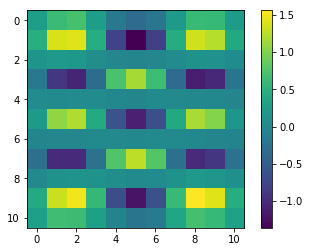

In [90]:
plt.imshow(DMM_U.reshape(sqrtinputsize,sqrtinputsize))
plt.colorbar()

Residual

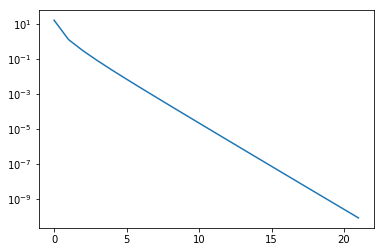

In [91]:
plt.semilogy(DMM_Res)

Radius

In [92]:
DMM_Radius = Rhonew
print('DMM_Radius = {}'.format(DMM_Radius))

DMM_Radius = 0.33562093897692846


In [93]:
wnew

array(0.8008967)

Rrestriction matrix after optimization

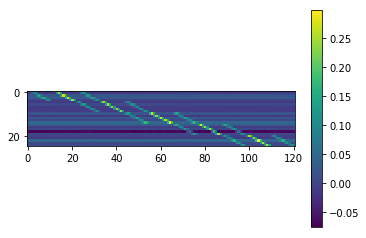

In [94]:
plt.imshow(Rnew)
plt.colorbar()

Rrestriction matrix (log(abs()) after optimization

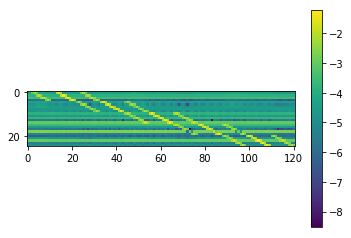

In [95]:
plt.imshow(np.log(np.abs(Rnew)))
plt.colorbar()

Basis after optimization

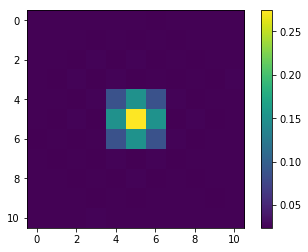

In [96]:
basis1 = Rnew[int(0.5*outputsize)][:]
basis1 = basis1.reshape([sqrtinputsize,sqrtinputsize])
plt.imshow(basis1)
plt.colorbar()

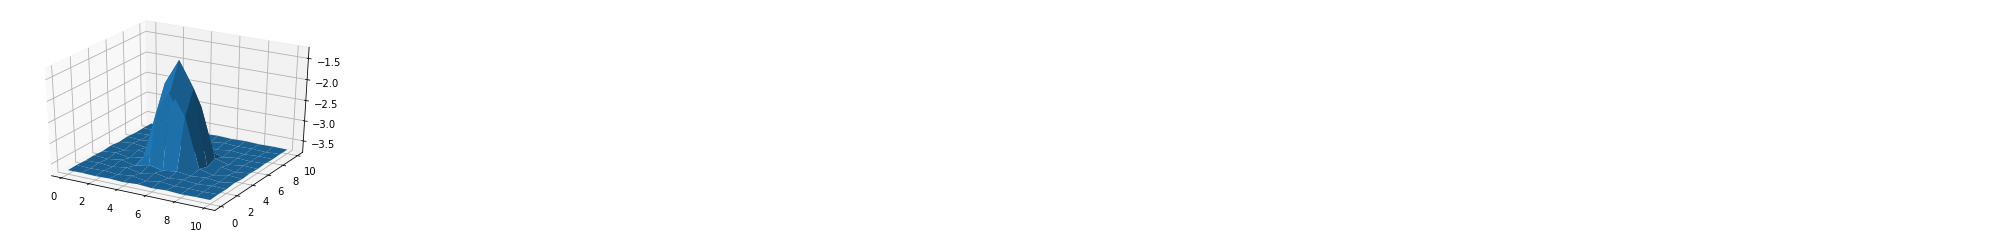

In [97]:
from matplotlib import pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
size=basis1.shape
Y=np.arange(0,size[0],1)     
X=np.arange(0,size[1],1)

X,Y=np.meshgrid(X,Y)    
fig=plt.figure()
ax=fig.gca(projection='3d') 
ax.plot_surface(X,Y,np.log(abs(basis1)))
plt.show()

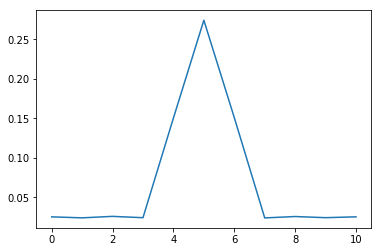

In [98]:
plt.plot(basis1[:][int(sqrtinputsize/2)])

Basis after optimization (log(abs()))

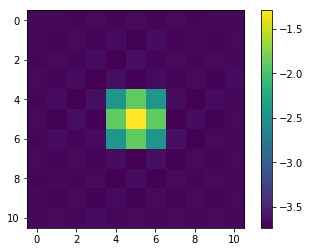

In [99]:
plt.imshow(np.log(np.abs(basis1)))
plt.colorbar()

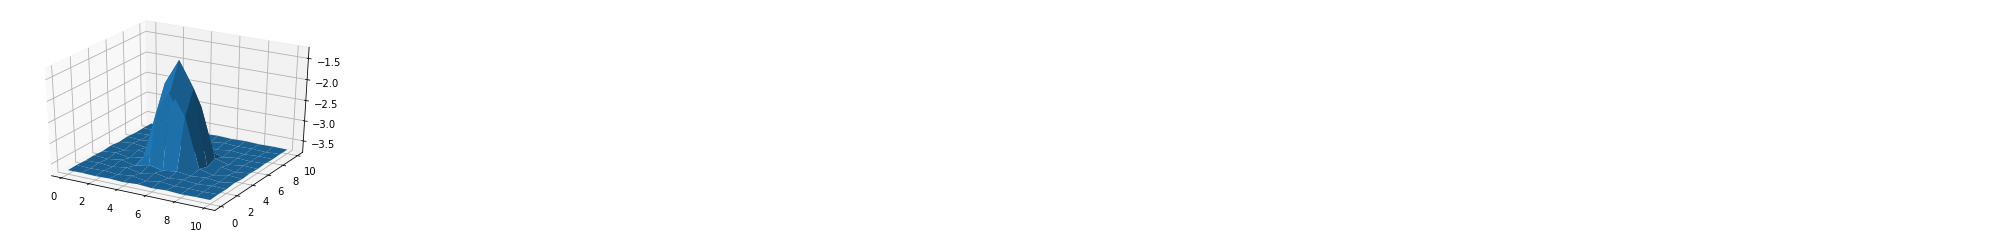

In [100]:
fig=plt.figure()
ax=fig.gca(projection='3d') 
ax.plot_surface(X,Y,np.log(np.abs(basis1)))
plt.show()

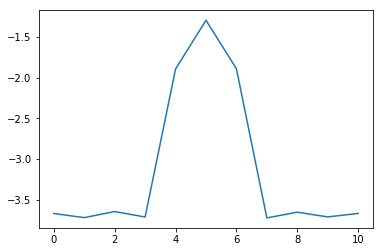

In [101]:
plt.plot(np.log(np.abs(basis1[:][int(sqrtinputsize/2)])))

FEM use basis from global DMM

Energy norm: 
12.04219014051568
L2 norm: 
2.3023585861175078
H1 norm: 
8.80019686767165
Energy norm: 
1.2113924299224366
L2 norm: 
4.6047171722350155
H1 norm: 
1.2459662824327293


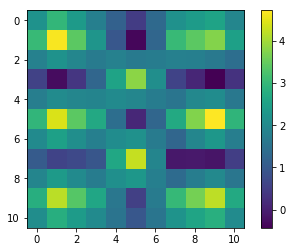

In [102]:

Anew = np.zeros([outputsize,outputsize])
[X1, Y1] = np.meshgrid(np.linspace(0, 1, sqrtinputsize),np.linspace(0, 1, sqrtinputsize))
[X2, Y2] = np.meshgrid(np.linspace(0, 1, sqrtoutputsize),np.linspace(0, 1, sqrtoutputsize))
A = a(X1,Y1)
for i in range(outputsize):
    for j in range(outputsize):
        basisi = Rnew[i][:].reshape([sqrtinputsize,sqrtinputsize])
        basisj = Rnew[j][:].reshape([sqrtinputsize,sqrtinputsize])
        gxbasisi = np.gradient(basisi,axis=0)/h
        gybasisi = np.gradient(basisi,axis=1)/h
        gxbasisj = np.gradient(basisj,axis=0)/h
        gybasisj = np.gradient(basisj,axis=1)/h
        Anew[i][j]=(np.sum(A*gxbasisi*gxbasisj)+np.sum(A*gybasisi*gybasisj))*(H**2)
        
Fnew = np.zeros([outputsize,1])
for i in range(outputsize):
    basisi = Rnew[i][:].reshape([sqrtinputsize,sqrtinputsize])
    F = rightf(X1,Y1)
    Fnew[i]=np.sum(F*basisi)*(H**2)
    
UnewCoarse = np.linalg.solve(Anew,Fnew)
Unew = np.zeros([sqrtinputsize,sqrtinputsize])
for i in range(outputsize):
    basisi = Rnew[i][:].reshape([sqrtinputsize,sqrtinputsize])
    Unew = Unew + UnewCoarse[i]*basisi

plt.imshow(Unew)
plt.colorbar()

UREAL = u_real(X1,Y1).reshape(sqrtinputsize,sqrtinputsize)
deltaU = Unew - UREAL
A = a(X1,Y1)

energynorm = np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=0),np.gradient(UREAL,h,axis=0)),A)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(UREAL,h,axis=1),np.gradient(UREAL,h,axis=1)),A)*(h**2)))
l2norm = np.sqrt((np.sum(UREAL**2))*(h**2))
h1norm = np.sqrt((np.linalg.norm(np.gradient(UREAL,h,axis=0))**2+np.linalg.norm(np.gradient(UREAL,h,axis=1))**2+np.linalg.norm(UREAL)**2)*(h**2))
print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),A)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),A)*(h**2))))
print('L2 norm: ')
print(np.sqrt((np.linalg.norm(deltaU)**2)*(h**2)))
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2)))



print('Energy norm: ')
print(np.sqrt(np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=0),np.gradient(deltaU,h,axis=0)),A)*(h**2))+np.sum(np.multiply(np.multiply(np.gradient(deltaU,h,axis=1),np.gradient(deltaU,h,axis=1)),A)*(h**2)))/energynorm)
print('L2 norm: ')
print(np.sqrt((np.sum(deltaU**2))*(h**2))/l2norm)
print('H1 norm: ')
print(np.sqrt((np.linalg.norm(np.gradient(deltaU,h,axis=0))**2+np.linalg.norm(np.gradient(deltaU,h,axis=1))**2+np.linalg.norm(deltaU)**2)*(h**2))/h1norm)

In [103]:
import os
os.system("say 'The program has finished, Please check the results'")

0